In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import re
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import palettable
from IPython.display import display


import tempfile
import subprocess as sp
from joblib import parallel_backend

from matplotlib import gridspec

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata
from geneset_testing import load_geneset

from scipy.stats import fisher_exact, ranksums
from sklearn.preprocessing import scale

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # Lets you edit pdfs in illustrator


def draw_box(xvars, yvars, ax, linestyle='--', color='k',
             linewidth=.5, skipline=[0,0,0,0]):
    cords = [0, 1, 2, 3, 0]
    for i in range(4):
        p1 = cords[i]
        p2 = cords[i+1]
        if skipline[i]!=1:
          ax.plot([xvars[p1], xvars[p2]], [yvars[p1], yvars[p2]],
                linestyle=linestyle, color=color, linewidth=linewidth)
        
        
def get_box_ind(xbound, ybound, xvals, yvals):
    cords = [0, 1, 2, 3, 0]
    ind = np.array([True]*len(xvals))
    for i in range(4):
        p1 = cords[i]
        p2 = cords[i+1]
        if (xbound[p2] - xbound[p1]) != 0:
            m = (ybound[p2] - ybound[p1]) / (xbound[p2] - xbound[p1])
            if i in [0, 3]:
                ind = ind & (yvals > (m*xvals-m*xbound[p1]+ybound[p1]))
            else:
                ind = ind & (yvals < (m*xvals-m*xbound[p1]+ybound[p1]))
        else:
            if i in [0, 3]:
                ind = ind & (xvals > xbound[p2])
            else:
                ind = ind & (xvals < xbound[p2])
            
    return(ind)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100, vector_friendly=True)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
import os
adir = '../../../../data/InVivo/Seqwell/'
project_name = 'invivo_all_20200318_mmul8_V4_fixid'
gcs = False

results_dir = '../../../../results'

count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

abase = os.path.join(adir, project_name)
abase

'../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid'

## UMAP or monocytes

In [4]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata_annot = read_adata(annot_file, gcs=False)
adata_annot.obs['Subclustering_reduced'] = adata_annot.obs['SubclusteringGroup'].apply(lambda x: x.split('_')[0])

adata_annot

Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].


AnnData object with n_obs × n_vars = 56929 × 16946 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced', 'Soup_Usage', 'ebola_infection_threshold', 'Ebola_Positive'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blackli

In [5]:
## New sample set new blacklist set
adata_raw = sc.AnnData(X=adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
monocyte_ind = (adata_raw.obs['Subclustering_reduced']=='Mono')

adata = adata_raw[monocyte_ind, :]
sc.pp.filter_genes(adata, min_cells=10)
adata.raw = adata.copy()
print(adata.raw.var['Combined_Blacklist'].value_counts())
genestokeep = ~(adata.var['Combined_Blacklist'] | adata.var['CC_Blacklist'])
adata = adata[:, genestokeep]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=None)
adata = adata[:,adata.var['highly_variable']]

filtered out 5250 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


False    11699
True       188
Name: Combined_Blacklist, dtype: int64
normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [6]:
sc.pp.scale(adata, max_value=10)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
sc.pp.pca(adata, svd_solver='arpack', random_state=14)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)


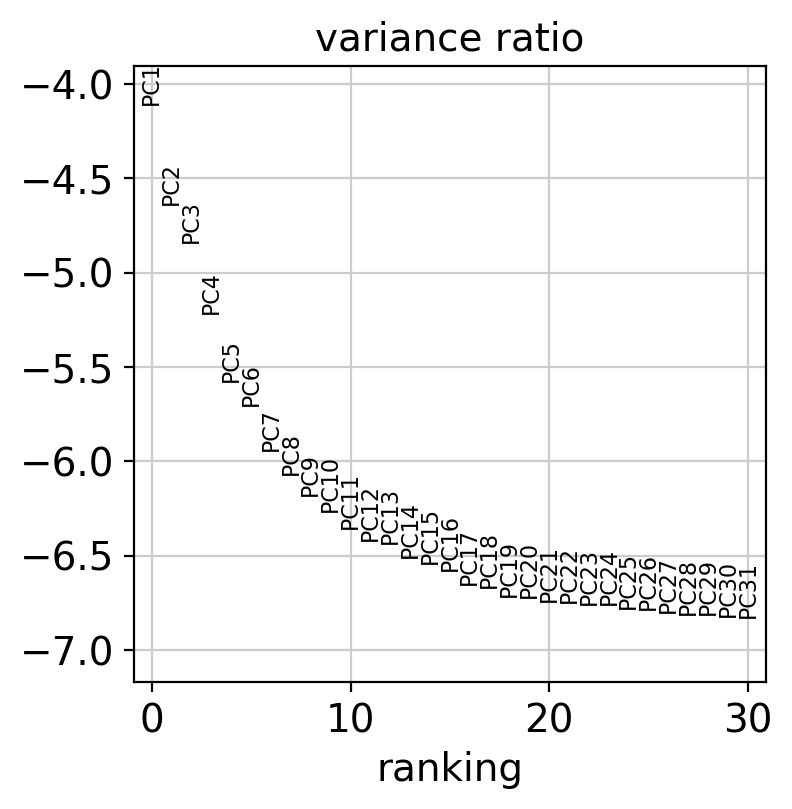

In [8]:
sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
print(int(adata.shape[0]*.001), adata.shape[0])
sc.pp.neighbors(adata, n_pcs=18, n_neighbors=30, random_state=14)

6 6976
computing neighbors
    using 'X_pca' with n_pcs = 18
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)


In [10]:
sc.tl.umap(adata, min_dist=0.1, spread=2.0, random_state=14)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)


... storing 'Subclustering_reduced' as categorical


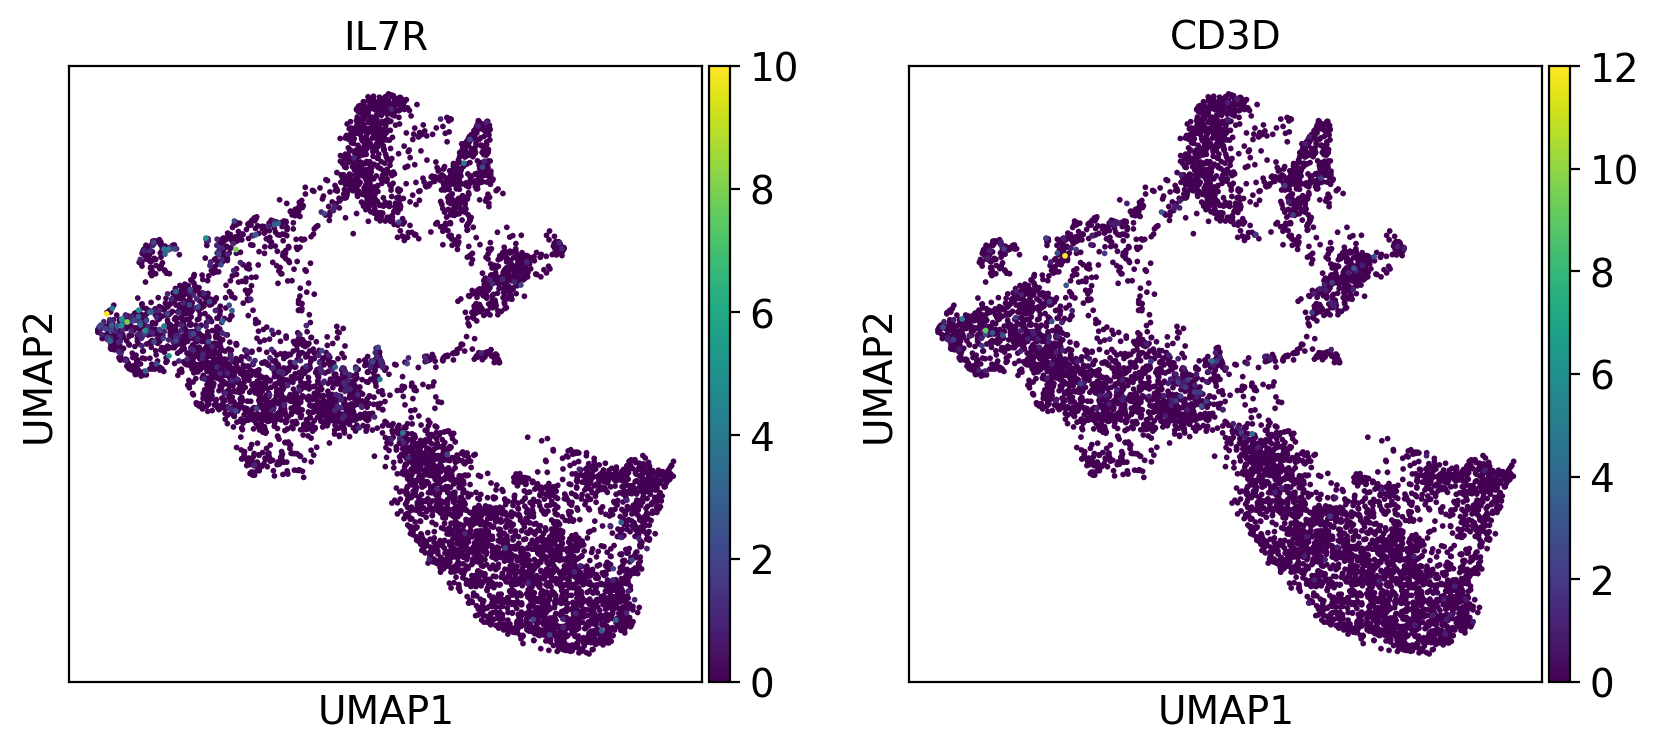

In [11]:
sc.pl.umap(adata, color=['IL7R', 'CD3D'])

In [12]:
sc.tl.leiden(adata, resolution=1.5, random_state=14)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


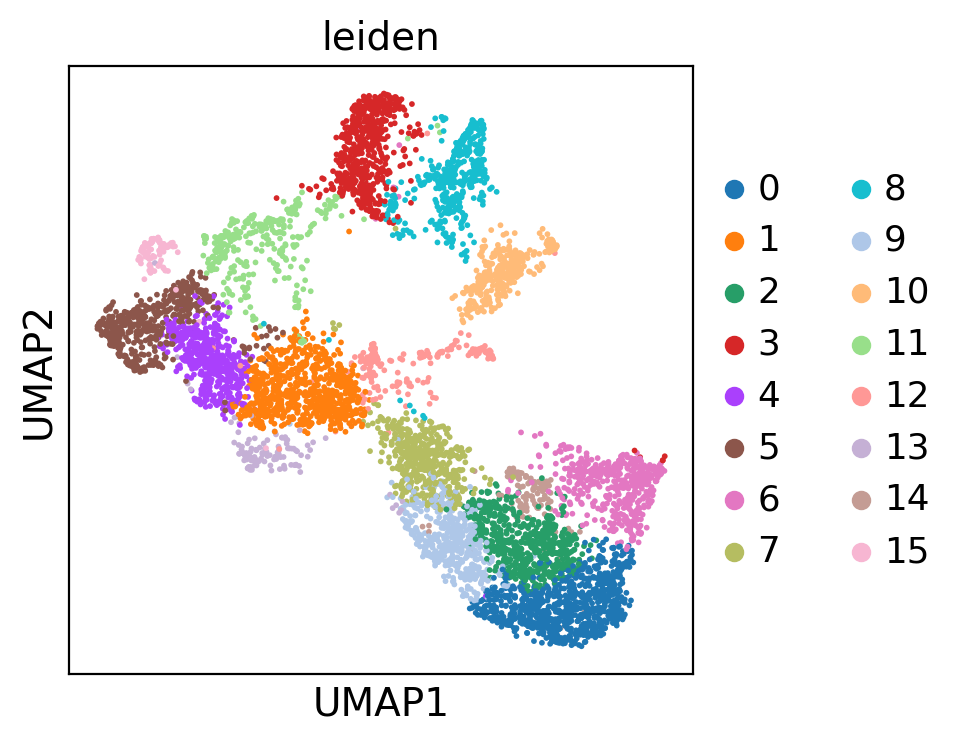

In [13]:
sc.pl.umap(adata, color='leiden')

In [14]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


In [15]:
pd.DataFrame(adata.uns['rank_genes_groups']['names'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,VIM,GNLY,FOS,CFD,RPS4Y1,H2AFV,MAMU-DPA,ENSMMUG00000011746,CFD,QPCT,SORL1,C3,ENSMMUG00000048806,S100A9,RPL31,S100A9
1,VCAN,LCK,LGALS3,MS4A7,DDX60L,ANP32B,ENSMMUG00000047461,TRBV24-1,HERC1,TREM1,PLCB2,IFIT3,ENSMMUG00000029374,S100A8,RPS4Y1,ISG15
2,KLF6,ENSMMUG00000038528,VIM,SELENOP,ISG15,PSMA2,APOBEC3A,SEZ6,MTSS1,MMP1,RPS4Y1,SDC3,MAMU-B18,MCEMP1,IL1B,SLC16A3
3,SELL,CD3D,HIF1A,FCGR3,IFI44,CLU,LGMN,MUC3A,ITGAX,BMX,EGR1,NR1H3,ENSMMUG00000044632,VNN2,ATP2B1,ENSMMUG00000028701
4,FOS,ENSMMUG00000046487,ANXA1,LTA4H,S100A9,PSMA4,IFI30,CAMK4,VMO1,SELL,CTSK,PLA2G4C,ENSMMUG00000006383,ACSL1,NFKBIZ,MVP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,DDX5,ENSMMUG00000038060,REEP5,TXNIP,ADCY4,GNG11,TSC22D3,LEPROT,SUN2,NKD1,CNN2,CREG1,ENSMMUG00000030356,PTPN12,MNDA,ATP6V1B2
96,ENSMMUG00000001764,IGHM,RTN4,ABHD3,TLE2,AKR1A1,AIM2,ENSMMUG00000030791,PCNT,BAIAP3,NOTCH2,AIF1,ND5,ALAS1,SLC18B1,GDI1
97,STX3,ADAMTS4,ALOX5AP,CEPT1,GOLGB1,SDHB,BACH1,AMMECR1,RSBN1,ENSMMUG00000038497,SLC8B1,SCARB2,ENSMMUG00000031260,PICALM,UPP1,GMFG
98,SLC25A37,ENSMMUG00000042951,EEF1B2,NOCT,USP22,LCP1,BIN2,CD3G,BANP,ENSMMUG00000046173,ENSMMUG00000022334,ENSMMUG00000045411,ENSMMUG00000032583,S100A4,SUCO,ADGRE1


In [16]:
pd.Series((adata.obs.index[adata.obs['leiden']=='8'])).apply(lambda x: x.split('.')[1]).value_counts()

D-30    180
D000    103
D-04     78
D003     58
D004     11
D006     11
D005      9
dtype: int64

## Make Monocyte UMAP plots

In [17]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [18]:
plotdata = adata.obs.copy()
plotdata['UMAP_1'] = adata.obsm['X_umap'][:,0]
plotdata['UMAP_2'] = adata.obsm['X_umap'][:,1]

colors = np.array([x for x in palettable.tableau.TrafficLight_9.hex_colors])
#sns.palplot(colors)
#sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(range(9), colors[[8,8,5, 7, 4, 1, 6,3,0]]))
dpimap[0] = palettable.tableau.TableauMedium_10.hex_colors[-1]

plotdata['dpi_color'] = plotdata['DPIc'].apply(lambda x: dpimap[int(x)])

plotdata['CD14'] = adata.obs_vector('CD14')
plotdata['FCGR3'] = adata.obs_vector('FCGR3')

In [19]:
diff_score_fn = os.path.join(adir, 'macrophage_differentiation_score.tsv')
mono_diff_obs = pd.read_csv(diff_score_fn, sep='\t', index_col=0)
mono_diff_obs.head()

,batch,DPI,DPIc,Period,full_sample_id,frz_status,sample_source,sample,array_num,array_id,...,Subclustering,Doublet,Subclustering_reduced,Soup_Usage,ebola_infection_threshold,Ebola_Positive,is_fresh,DPIc2,NR1H3,diff_score
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,Mono 4,False,Mono,0.055914,1,False,1,0,0.0,61.635471
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AACATATCACCC,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,Mono 4,False,Mono,0.061268,1,False,1,0,0.0,-53.043299
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AACTGACCCCCT,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,Mono 4,False,Mono,0.016820,1,False,1,0,0.0,32.341769
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_ACAACCCGCCGG,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,Mono 6,False,Mono,0.036724,1,False,1,0,0.0,-18.199051
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AGCACTCTCGGG,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,Mono 4,False,Mono,0.080137,1,False,1,0,0.0,-42.012902


In [374]:
plotdata['diff_score'] = mono_diff_obs.loc[plotdata.index, 'diff_score']

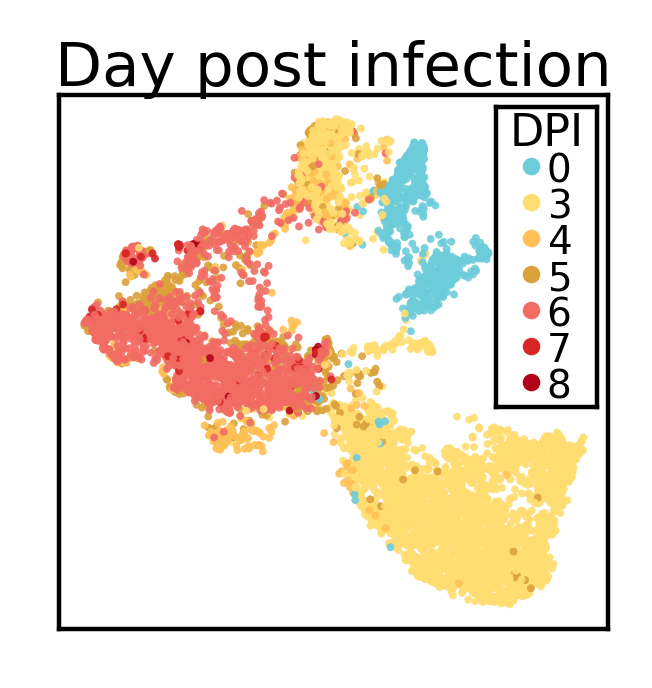

In [396]:
fig = plt.figure(figsize=(1.4, 1.5), dpi=200)
gs = gridspec.GridSpec(2, 1, fig, 0.01, 0.01, .99,.99,
                       hspace=0.05, wspace=0.05,
                       height_ratios=(.15, 2))

'''
full_border_ax = fig.add_subplot(gs[:],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])
'''

ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

s=2


ax.scatter(plotdata['UMAP_1'], plotdata['UMAP_2'], c=plotdata['dpi_color'],
           s=s, alpha=.9, edgecolor='None', rasterized=True)

#ax.set_ylim([-5.272763752937317, 9.780792450904847])

#legend_ax = fig.add_axes([.78, .04, .18, .4], yticks=[], xticks=[])
legend_ax = fig.add_axes([.79,.38, .18, .5], yticks=[], xticks=[])
legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.35
vals = [0, 3, 4, 5, 6, 7, 8]
for (i,(v, y)) in enumerate(zip(vals[::-1], np.linspace(.08, .8, num=len(vals)))):
  legend_ax.scatter(marker_x, y, color=dpimap[v], s=10, edgecolor='None')
  legend_ax.text(marker_x+.15, y-.05, v, fontsize=7)

legend_ax.text(.5, .87, 'DPI', fontsize=8, ha='center')


title_ax = fig.add_subplot(gs[0, :],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 0.3, 'Day post infection', va='center', ha='center',
              fontsize=11,
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.SeqwellMonocyte.Invivo.DPI.pdf")
fig.savefig(figure_file, dpi=300)

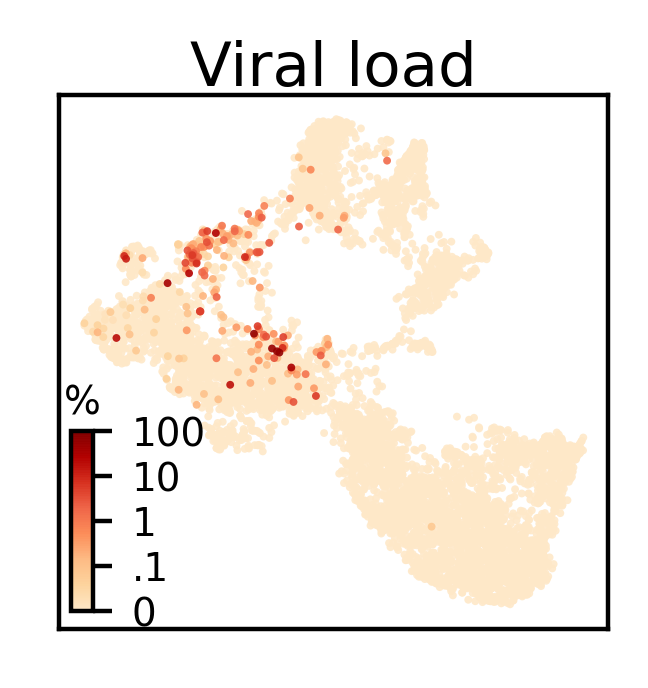

In [398]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
ebov_cmap = LinearSegmentedColormap.from_list(name='ebov_cmap', colors=palettable.colorbrewer.sequential.OrRd_9.mpl_colors[1:])

fig = plt.figure(figsize=(1.4, 1.5), dpi=200)
gs = gridspec.GridSpec(2, 1, fig, 0.01, 0.01, .99,.99,
                       hspace=0.05, wspace=0.05,
                       height_ratios=(.15, 2))



ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

s=2

plotdata_sorted = plotdata.sort_values(by='log10_EBOV_TPT')
cbarim = ax.scatter(plotdata_sorted['UMAP_1'], plotdata_sorted['UMAP_2'],
                    c=plotdata_sorted['log10_EBOV_TPT'], vmin=0, vmax=4,
           s=s, alpha=.9, edgecolor='None', cmap=ebov_cmap, rasterized=True)

#ax.set_ylim([-5.272763752937317, 9.780792450904847])


cbar_ax = fig.add_axes([0.03,0.04, .04, .3])


fig.colorbar(cbarim, cax=cbar_ax, ticks=[0,1,2,3,4])
#cbar_ax.set_yticks([0, 1, 2, 3, 4])
cbar_ax.set_yticklabels(['0', '.1', '1', '10', '100'])
cbar_ax.set_title('%', fontsize=7, pad=3)

title_ax = fig.add_subplot(gs[0, :],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 0.3, 'Viral load', va='center', ha='center',
              fontsize=11,clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.SeqwellMonocyte.Invivo.EBOV.pdf")
fig.savefig(figure_file, dpi=300)

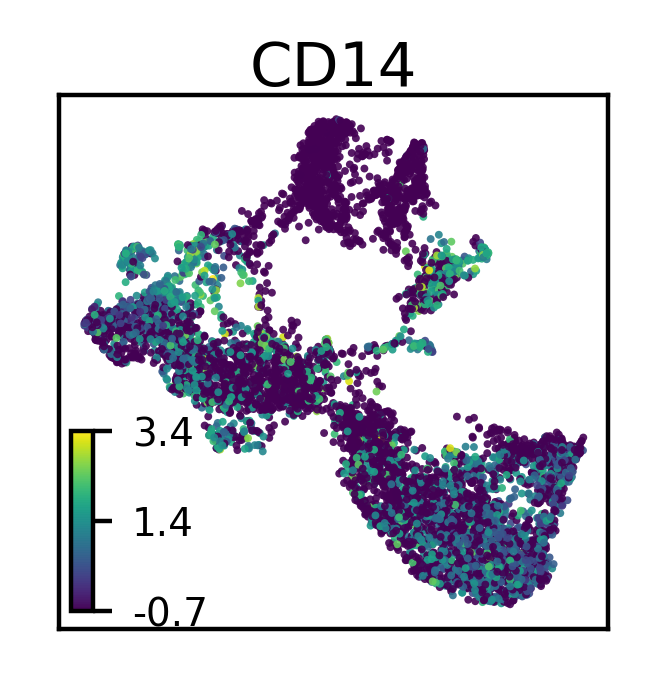

In [400]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
gene_cmap = 'viridis'

fig = plt.figure(figsize=(1.4, 1.5), dpi=200)
gs = gridspec.GridSpec(2, 1, fig, 0.01, 0.01, .99,.99,
                       hspace=0.05, wspace=0.05,
                       height_ratios=(.15, 2))


ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

s=2
g = 'CD14'
plotdata_sorted = plotdata #.sort_values(by=g)
vmin = plotdata_sorted[g].min()
vmax = plotdata_sorted[g].max()
cbarim = ax.scatter(plotdata_sorted['UMAP_1'], plotdata_sorted['UMAP_2'],
                    c=plotdata_sorted[g], vmin=vmin, vmax=vmax,
           s=s, alpha=.9, edgecolor='None', cmap=gene_cmap, rasterized=True)
#ax.set_ylim([-5.272763752937317, 9.780792450904847])

cbar_ax = fig.add_axes([0.03,0.04, .04, .3])

ticks = np.linspace(vmin, vmax, 3)
ticklabs = ['%.1f' % x for x in ticks]

fig.colorbar(cbarim, cax=cbar_ax, ticks=ticks)
cbar_ax.set_yticklabels(ticklabs)

title_ax = fig.add_subplot(gs[0, :],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 0.3, g, va='center', ha='center',
              fontsize=11,clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.SeqwellMonocyte.Invivo.Invivo.CD14.pdf")
fig.savefig(figure_file, dpi=300)

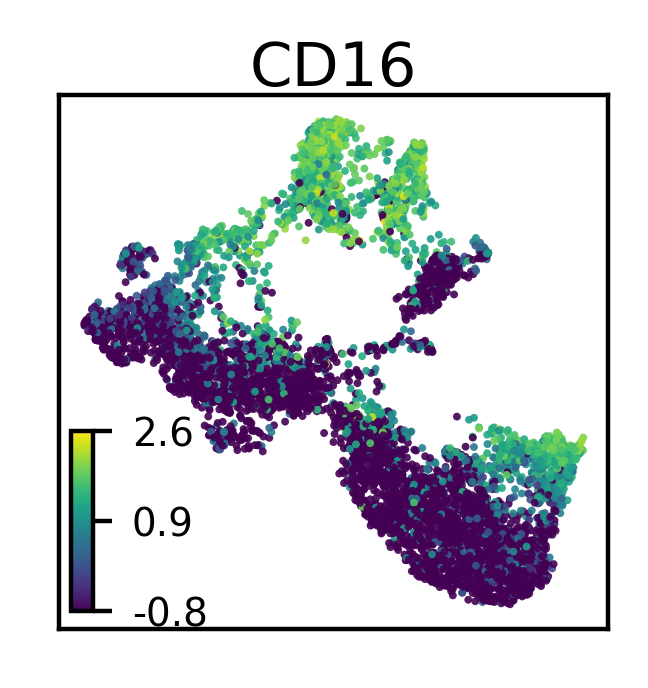

In [401]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
gene_cmap = 'viridis'

fig = plt.figure(figsize=(1.4, 1.5), dpi=200)
gs = gridspec.GridSpec(2, 1, fig, 0.01, 0.01, .99,.99,
                       hspace=0.05, wspace=0.05,
                       height_ratios=(.15, 2))

ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

s=2
g = 'FCGR3'
plotdata_sorted = plotdata #.sort_values(by=g)
vmin = plotdata_sorted[g].min()
vmax = plotdata_sorted[g].max()
cbarim = ax.scatter(plotdata_sorted['UMAP_1'], plotdata_sorted['UMAP_2'],
                    c=plotdata_sorted[g], vmin=vmin, vmax=vmax,
           s=s, alpha=.9, edgecolor='None', cmap=gene_cmap, rasterized=True)

cbar_ax = fig.add_axes([0.03,0.04, .04, .3])

ticks = np.linspace(vmin, vmax, 3)
ticklabs = ['%.1f' % x for x in ticks]

fig.colorbar(cbarim, cax=cbar_ax, ticks=ticks)
cbar_ax.set_yticklabels(ticklabs)

title_ax = fig.add_subplot(gs[0, :],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 0.3, 'CD16', va='center', ha='center',
              fontsize=11,clip_on=False)


figure_file = os.path.join(results_dir, "UMAP.SeqwellMonocyte.Invivo.CD16.pdf")
fig.savefig(figure_file, dpi=300)

## Run MAGIC to get smoothed CD14 and CD16 values

In [25]:
adata_full = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var)

In [26]:
adata_full.var['Combined_Blacklist'].value_counts()

False    11699
True       188
Name: Combined_Blacklist, dtype: int64

In [27]:
adata_full = adata_full[:, adata_full.var['Combined_Blacklist']==False]

In [28]:
sc.pp.normalize_per_cell(adata_full,counts_per_cell_after=10000)
sc.pp.log1p(adata_full)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [29]:
import magic
magic_operator = magic.MAGIC(knn_dist='cosine', t=3, random_state=14)
X_magic = magic_operator.fit_transform(adata_full, genes=['CD14', 'FCGR3', 'MKI67'])

Calculating MAGIC...
  Running MAGIC on 6976 cells and 11699 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.35 seconds.
    Calculating affinities...
    Calculated affinities in 7.30 seconds.
  Calculated graph and diffusion operator in 20.77 seconds.
  Calculating imputation...
Calculated MAGIC in 20.88 seconds.


/home/dkotliar/.local/lib/python3.7/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


In [30]:
plotdata['MAGIC_CD14'] = X_magic[plotdata.index, :].obs_vector('CD14')
plotdata['MAGIC_CD16'] = X_magic[plotdata.index, :].obs_vector('FCGR3')
plotdata['MAGIC_KI67'] = X_magic[plotdata.index, :].obs_vector('MKI67')

## 2D plots

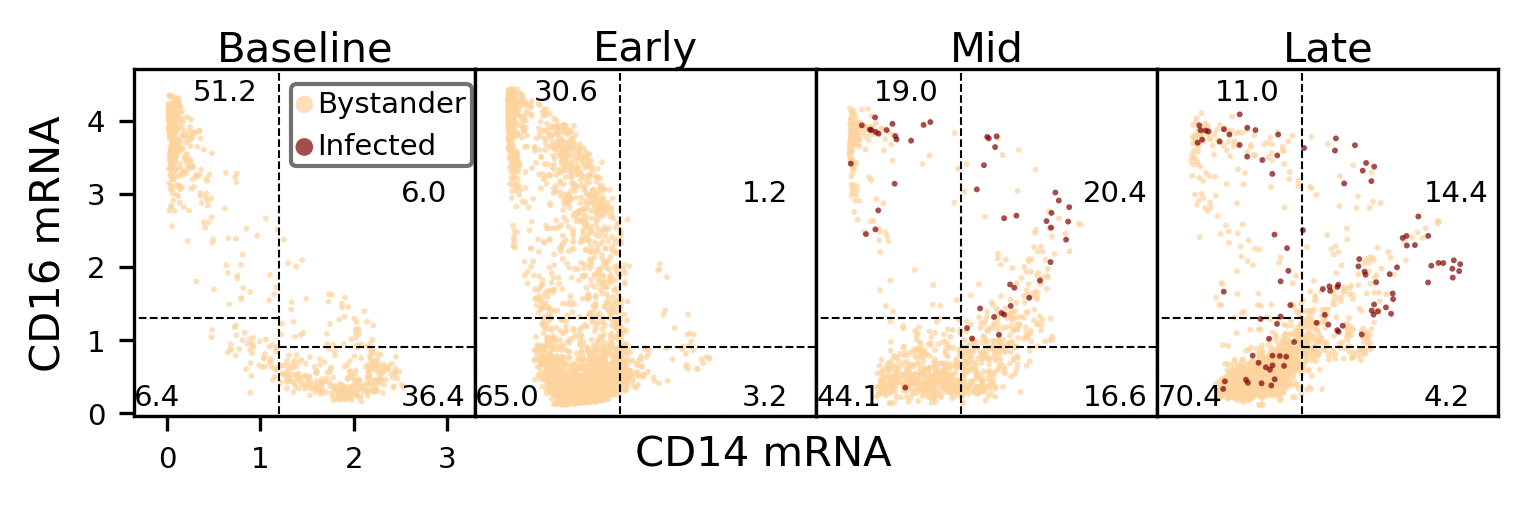

In [185]:
## New sample set new blacklist set

fig = plt.figure(figsize=(5, 1.6), dpi=150)
gs = gridspec.GridSpec(1, 4, fig, left=.5/6.2, bottom=.2/1.8,
                       right=.99,top=1.5/1.8,
                       hspace=0, wspace=0)

axes = [fig.add_subplot(gs[i]) for i in range(4)]

c = 'log10_EBOV_TPT'
cbin = 'Ebola_Positive'
g1 = 'MAGIC_CD14'
g2 = 'MAGIC_CD16'
percent_lab_fontsize=7

baseline_color = '0.8'
#baseline_color = dpimap[0]

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
ebov_cmap = LinearSegmentedColormap.from_list(name='ebov_cmap', colors=palettable.colorbrewer.sequential.OrRd_9.mpl_colors[1:])
#ebov_cmap = 'viridis'

infected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[-1]
uninfected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[2] 

xlim = [-.35, 3.3]
ylim = [-0.04, 4.7]



cd14_box = [1.2,1.2,xlim[1],xlim[1]], [ylim[0], .9, .9, ylim[0]]
dneg_box2 = [xlim[0], xlim[0], 1.2, 1.2], [ylim[0], 1.3, 1.3, ylim[0]]
cd16_box = [xlim[0],xlim[0],cd14_box[0][0], cd14_box[0][0]], [dneg_box2[1][2], 4.8, 4.8, dneg_box2[1][2]]
loc_pos = [(2.5, .1), (-.35, .1), (0.27, 4.27), (2.5,2.9)]
linetoskip = [[1,0,0,0], [0, 1, 0, 0], [0, 0,0,0]]

for (i, period) in enumerate(['Baseline', 'Early', 'Mid','Late']):
    plotnum = i
    ax = axes[plotnum]
    ind = plotdata['Period'] == period
    order = ind.index[ind]
    #order = plotdata.loc[ind,c].sort_values(ascending=True).index
    ax.tick_params(labelsize=7)
    #axes[plotnum].scatter(plotdata.loc[order,g1],plotdata.loc[order,g2], s=2, alpha=.7, edgecolor='None', color=dpimap[6])
    #ax.scatter(plotdata.loc[order,g1],plotdata.loc[order,g2], s=2, alpha=.7, edgecolor='None', c=plotdata.loc[order,c],
    #                      cmap=ebov_cmap, vmin=0, vmax=4)
    
    ind_pos = ind & (plotdata[cbin]==True)
    ind_neg = ind & (plotdata[cbin]==False)
    ax.scatter(plotdata.loc[ind_neg,g1],plotdata.loc[ind_neg,g2], s=2, alpha=.7, edgecolor='None',
               color=uninfected_color)    
    ax.scatter(plotdata.loc[ind_pos,g1],plotdata.loc[ind_pos,g2], s=2, alpha=.7, edgecolor='None',
               color=infected_color)    
    
    ax.set_title(period, fontsize=10, pad=0)
    ax.grid(False)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    num_cells = []
    num_pos_cells = []
    plotdata_period = plotdata.loc[ind,:]
    for (i,box) in enumerate([cd14_box, dneg_box2, cd16_box]):
        draw_box(box[0], box[1], ax=ax, skipline=linetoskip[i])
        ind_box = get_box_ind(box[0], box[1], plotdata_period[g1], plotdata_period[g2])
        num_cells.append(ind_box.sum())

    num_cells.append(plotdata_period.shape[0] - sum(num_cells))
    num_cells = np.array(num_cells)
    frac_cells = num_cells / num_cells.sum()
    percent_str = ['%.1f' % (x*100) for x in (frac_cells)]
    for i in range(len(loc_pos)):
        ax.text(loc_pos[i][0], loc_pos[i][1], percent_str[i], fontsize=percent_lab_fontsize)

axes[0].scatter([],[], s=2, alpha=.7, edgecolor='None',
               color=uninfected_color, label='Bystander') 
axes[0].scatter([],[], s=2, alpha=.7, edgecolor='None',
               color=infected_color, label='Infected') 
axes[0].legend(loc=(.46,.72), fontsize=7, markerscale=3, handletextpad=0.2, borderpad=0.2,
               edgecolor=".3")
axes[0].set_ylabel('CD16 mRNA', fontsize=10)
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_yticks([0,1,2,3,4])

plt.figtext(.5, 0.03, 'CD14 mRNA', ha='center', va='center', fontsize=10)

figure_file = os.path.join(results_dir, "MonoCD14CD16shift.Invivo.Seqwell.Ebola.Scatter.pdf")
fig.savefig(figure_file, dpi=200)

In [186]:
plotdata['Category'] = 'DP'
for (box, cat) in zip([cd14_box, cd16_box, dneg_box2], ['CD14+', 'CD16+', 'DN']):
    ind_box = get_box_ind(box[0], box[1], plotdata[g1], plotdata[g2])
    plotdata.loc[ind_box, 'Category'] = cat

In [187]:
plotdata['MAGIC_KI67'].min(), plotdata['MAGIC_KI67'].max()

(0.0, 2.9360812)

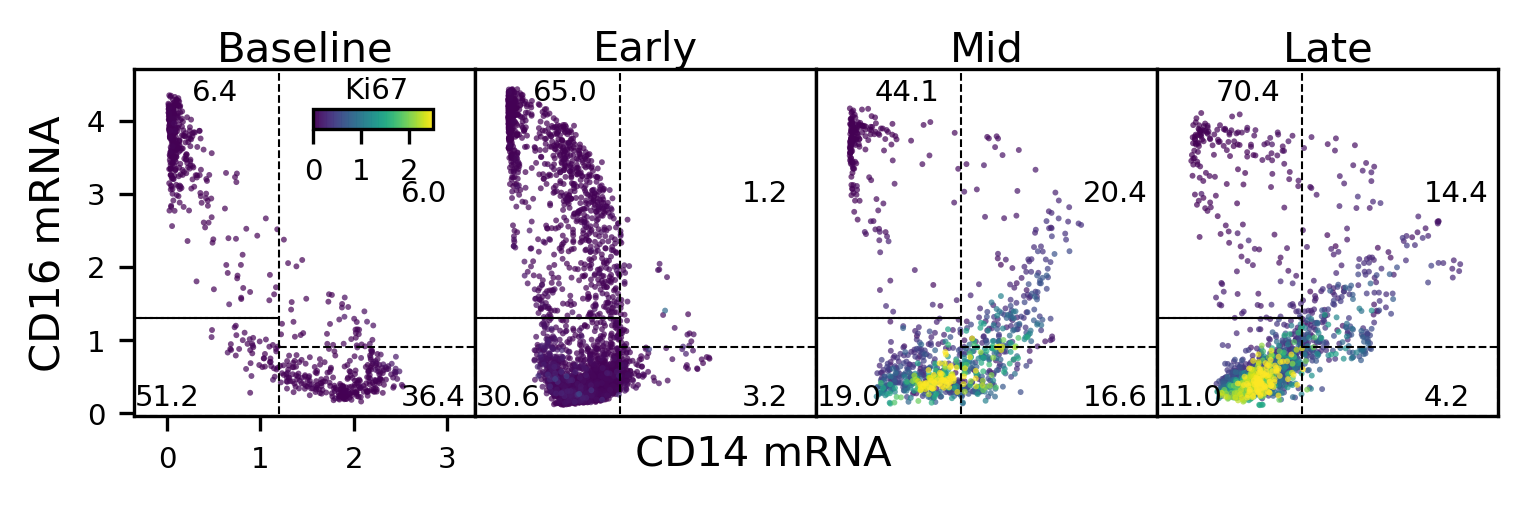

In [188]:
## New sample set new blacklist set

fig = plt.figure(figsize=(5, 1.6), dpi=150)
gs = gridspec.GridSpec(1, 4, fig, left=.5/6.2, bottom=.2/1.8,
                       right=.99,top=1.5/1.8,
                       hspace=0, wspace=0)

axes = [fig.add_subplot(gs[i]) for i in range(4)]

c = 'MAGIC_KI67'
cbin = 'Ebola_Positive'
g1 = 'MAGIC_CD14'
g2 = 'MAGIC_CD16'
percent_lab_fontsize=7

baseline_color = '0.8'

cmap = 'viridis'

infected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[-1]
uninfected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[2] 

xlim = [-.35, 3.3]
ylim = [-0.04, 4.7]
vmin = 0
vmax = 2.5


cd14_box = [1.2,1.2,xlim[1],xlim[1]], [ylim[0], .9, .9, ylim[0]]
dneg_box2 = [xlim[0], xlim[0], 1.2, 1.2], [ylim[0], 1.3, 1.3, ylim[0]]
cd16_box = [xlim[0],xlim[0],cd14_box[0][0], cd14_box[0][0]], [dneg_box2[1][2], 4.8, 4.8, dneg_box2[1][2]]
loc_pos = [(2.5, .1), (-.35, .1), (0.27, 4.27), (2.5,2.9)]
linetoskip = [[1,0,0,0], [0, 1, 0, 0], [0, 0,0,0]]

for (i, period) in enumerate(['Baseline', 'Early', 'Mid','Late']):
    plotnum = i
    ax = axes[plotnum]
    ind = plotdata['Period'] == period
    plotdata_period = plotdata.loc[ind,:]
    order = plotdata_period.loc[:,c].sort_values(ascending=True).index
    ax.tick_params(labelsize=7)

    cbarim = axes[plotnum].scatter(plotdata.loc[order,g1],plotdata.loc[order,g2],
                          c=plotdata.loc[order,c],
                          s=2, alpha=.7, edgecolor='None', vmin=vmin,
                          vmax=vmax, cmap=cmap)
    
    ax.set_title(period, fontsize=10, pad=0)
    ax.grid(False)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    num_cells = []
    num_pos_cells = []
    plotdata_period = plotdata.loc[ind,:]
    for (i,box) in enumerate([cd14_box, cd16_box, dneg_box2]):
        draw_box(box[0], box[1], ax=ax, skipline=linetoskip[i])
        ind_box = get_box_ind(box[0], box[1], plotdata_period[g1], plotdata_period[g2])
        num_cells.append(ind_box.sum())

    num_cells.append(plotdata_period.shape[0] - sum(num_cells))
    num_cells = np.array(num_cells)
    frac_cells = num_cells / num_cells.sum()
    percent_str = ['%.1f' % (x*100) for x in (frac_cells)]
    for i in range(len(loc_pos)):
        ax.text(loc_pos[i][0], loc_pos[i][1], percent_str[i], fontsize=percent_lab_fontsize)

cbar_ax = fig.add_axes([.2, .71, .08, .04])

#ticks=[0,1,2,3]
ticks = [0, 1, 2]
fig.colorbar(cbarim, cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar_ax.set_xticklabels(['0', '1', '2'])
axes[0].text(1.9,4.3,'Ki67', fontsize=7)


axes[0].set_ylabel('CD16 mRNA', fontsize=10)
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_yticks([0,1,2,3,4])

plt.figtext(.5, 0.03, 'CD14 mRNA', ha='center', va='center', fontsize=10)

figure_file = os.path.join(results_dir, "MonoCD14CD16shift.Invivo.SeqWell.CellCycleScore.Scatter.pdf")
fig.savefig(figure_file, dpi=200)

In [422]:
plotdata.groupby(['Period', 'Category'])['MAGIC_KI67'].agg(lambda x: (x>1).mean())

Period    Category
Baseline  CD14+       0.000000
          CD16+       0.000000
          DN          0.000000
          DP          0.000000
Early     CD14+       0.000000
          CD16+       0.000000
          DN          0.000000
          DP          0.000000
Late      CD14+       0.205882
          CD16+       0.000000
          DN          0.375436
          DP          0.068085
Mid       CD14+       0.365269
          CD16+       0.000000
          DN          0.373874
          DP          0.156098
Name: MAGIC_KI67, dtype: float32

In [423]:
plotdata.groupby(['Period'])['MAGIC_KI67'].agg(lambda x: (x>1).mean())

Period
Baseline    0.000000
Early       0.000000
Late        0.282822
Mid         0.257200
Name: MAGIC_KI67, dtype: float32

In [189]:
order = ['CD16+', 'DP', 'CD14+', 'DN']
category_palette_map = dict(zip(order, palettable.tableau.Tableau_10.hex_colors))

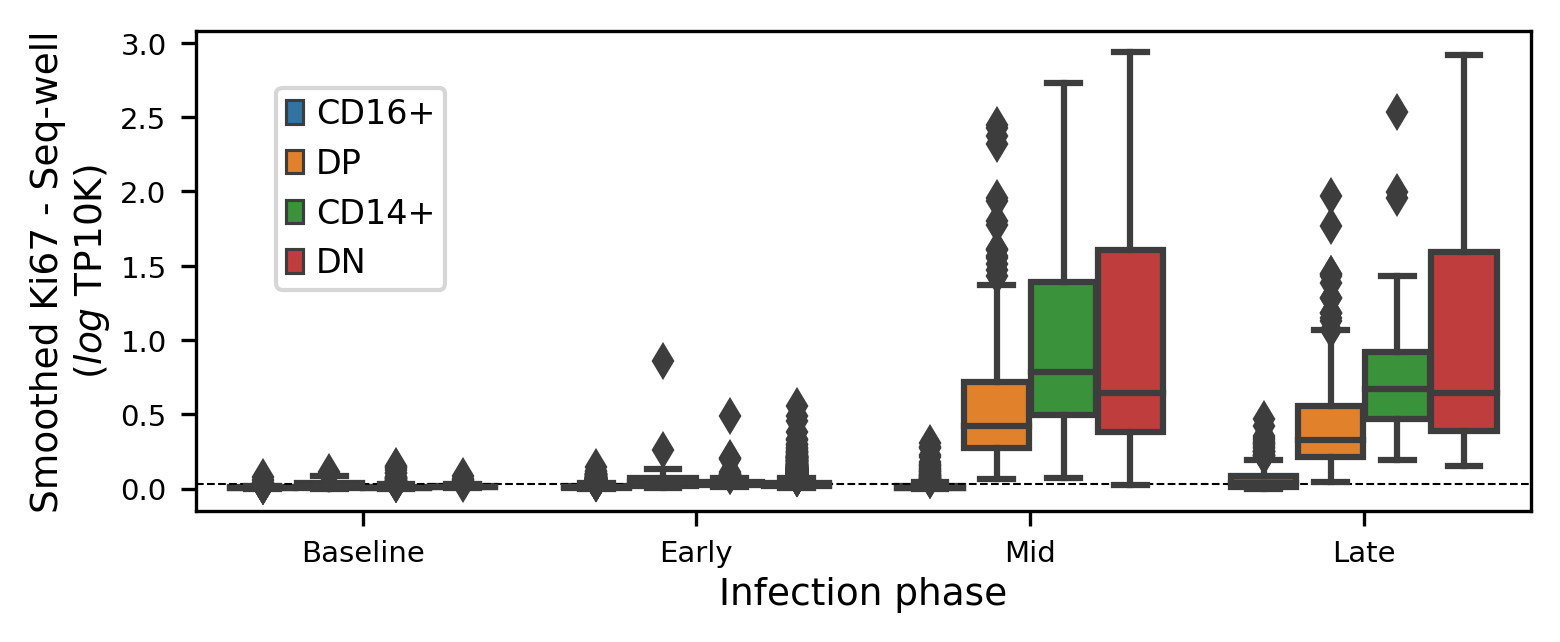

In [190]:
fig = plt.figure(figsize=(5, 2), dpi=150)
gs = gridspec.GridSpec(1, 1, fig, left=.1, bottom=.18, right=.99,top=.98,
                       hspace=0.05, wspace=0.05)
ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[])

hue_order = ['CD16+',  'DP', 'CD14+', 'DN']

order = ['Baseline', 'Early', 'Mid', 'Late']

#ax = sns.violinplot(x='Period', y='ccscore', data=plotdata, order=order,
#                 hue='Category', ax=ax, hue_order=hue_order, inner=None)


ax = sns.boxplot(x='Period', y='MAGIC_KI67', data=plotdata, order=order,
                 hue='Category', ax=ax, hue_order=hue_order, palette=category_palette_map)

median = plotdata['MAGIC_KI67'].median()
xlim = ax.get_xlim()
ax.hlines(y=median, xmin=xlim[0], xmax=xlim[1], linestyle='--', linewidth=.5)
ax.set_xlim(xlim)

ax.legend(loc=(0.06,.46), fontsize=8, title_fontsize=7, borderpad=.3)

ax.set_ylabel('Smoothed Ki67 - Seq-well\n($log$ TP10K)', labelpad=2)
ax.set_xlabel('Infection phase', labelpad=2)
ax.grid(False)


figure_file = os.path.join(results_dir, "Ki67MonoLevels.MonoCategoryAndPeriod.Invivo.Seqwell.Boxplot.pdf")
fig.savefig(figure_file, dpi=200)

No handles with labels found to put in legend.


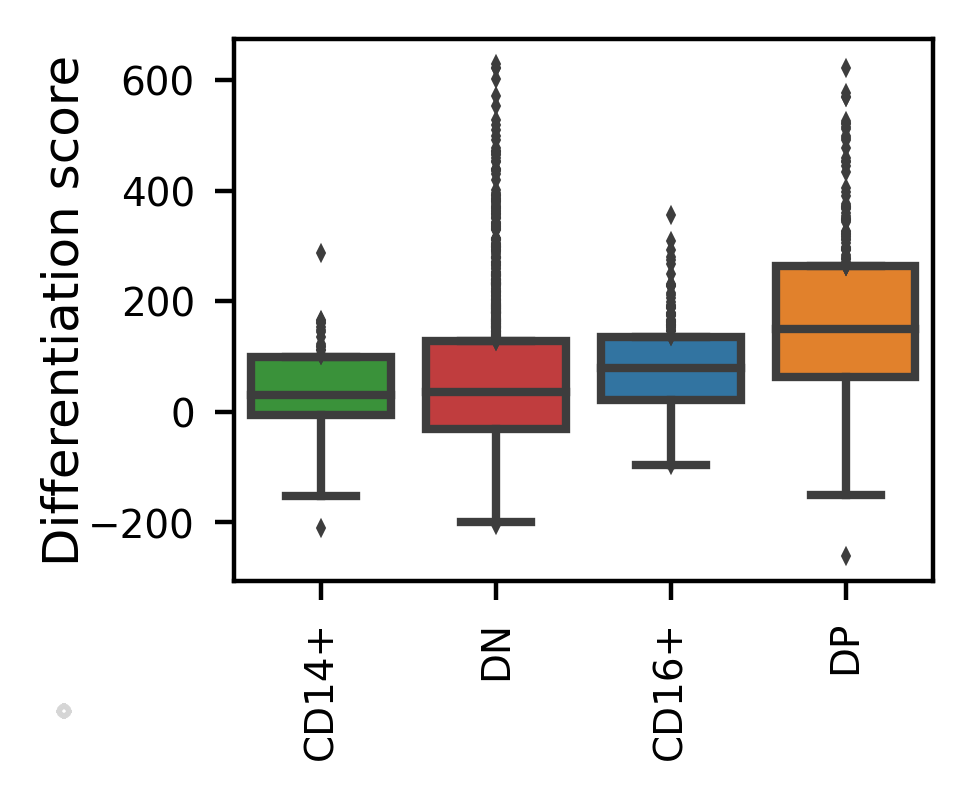

In [191]:
fig = plt.figure(figsize=(2.3, 2.15), dpi=200)
gs = gridspec.GridSpec(1, 1, fig, left=.23, bottom=.35, right=.99,top=.98,
                       hspace=0.05, wspace=0.05)
ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[])

order = ['CD14+', 'DN', 'CD16+', 'DP']

ind = plotdata['DPIc'].isin([ '6','7','8'])
ax = sns.boxplot(x='Category', y='diff_score', data=plotdata.loc[ind, :],
           order=order, palette=category_palette_map,
           ax=ax, whis=[.025, .975], fliersize=1,)
ax.set_xticklabels(order, rotation=90)
ax.legend(title=None, fontsize=6, loc=(-.25,-.25),
          borderpad=.15, handletextpad=.4)


ax.set_xlabel('')
ax.set_ylabel('Differentiation score', labelpad=0)

#ax.set_ylim([-443, 1200])
ax.grid(False)

figure_file = os.path.join(results_dir, "DiffScoreByMonoCategory.Late.Invivo.Seqwell.Boxplot.pdf")
fig.savefig(figure_file, dpi=200)

In [192]:
plotdata.loc[ind, :].groupby('Category')['diff_score'].median().sort_values()

Category
CD14+     29.658404
DN        36.241623
CD16+     78.510410
DP       149.048234
Name: diff_score, dtype: float64

In [6]:
plotdata['Ebola_Positive_100'] = plotdata['Ebola_Positive'].astype(int)*100

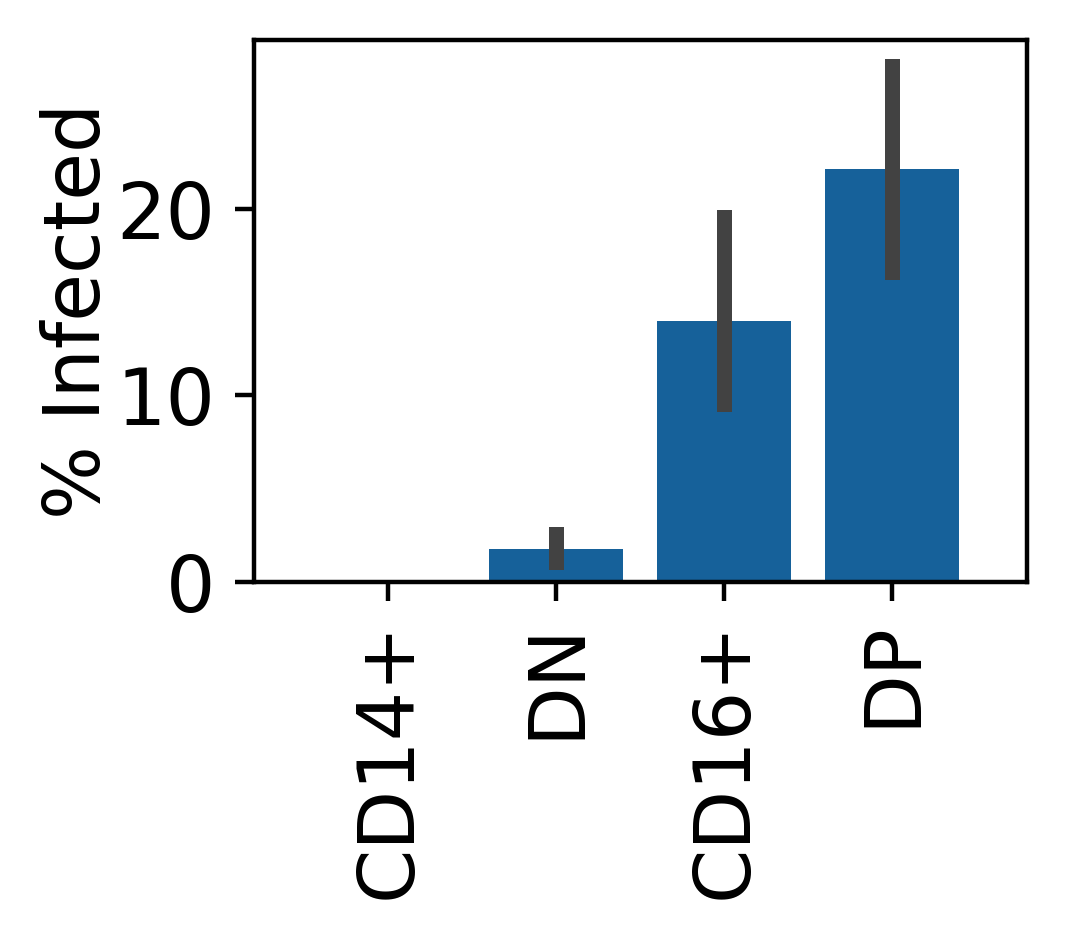

In [7]:
order = ['CD14+', 'DN', 'CD16+', 'DP']
ind = plotdata['Period'].isin(['Late'])

fig = plt.figure(figsize=(2.3, 2.15), dpi=200)
gs = gridspec.GridSpec(1, 1, fig, left=.15, bottom=.35, right=.99,top=.98,
                       hspace=0.05, wspace=0.05)
ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[])
#ax.set_ylim([0,45])

ax = sns.barplot(x='Category', y='Ebola_Positive_100', data=plotdata.loc[ind,:], order=order, ax=ax,
                color='#0064B0', ci=95)

ax.set_xticklabels(order, rotation=90)
ax.set_ylabel('% Infected', labelpad=0)
ax.set_xlabel('')

ax.set_xlim([-.8, 3.8])
ax.grid(False)

figure_file = os.path.join(results_dir, "InfectionFrac.MonoCategory.Invivo.Seqwell.Barplot.pdf")
fig.savefig(figure_file, dpi=200)

In [8]:
plotdata.loc[plotdata['Period']=='Late', :].groupby('Category')['Ebola_Positive_100'].mean()

Category
CD14+     0.00000
CD16+    13.96648
DN        1.74216
DP       22.12766
Name: Ebola_Positive_100, dtype: float64

In [9]:
ind = plotdata['Period'].isin(['Mid', 'Late'])
plotdata_late = plotdata.loc[ind,:]
plotdata_late['Category_Diff_Quantile'] = pd.qcut(plotdata_late['diff_score'], 2)
remap = dict(zip(list(plotdata_late['Category_Diff_Quantile'].cat.categories), ['low', 'high']))
plotdata_late['Category_Diff_Bin'] = plotdata_late['Category_Diff_Quantile'].replace(remap)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [10]:
for category in ['DN', 'CD16+', 'DP']:
    print(category)
    subdat = plotdata_late.loc[plotdata_late['Category']==category, :]
    ct = pd.crosstab(subdat['Category_Diff_Bin'], subdat['Ebola_Positive'])
    display(ct)
    print(fisher_exact(ct))

DN


Ebola_Positive,False,True
Category_Diff_Bin,,
high,718,11
low,853,10


(0.7652136843227113, 0.6605022222640164)
CD16+


Ebola_Positive,False,True
Category_Diff_Bin,,
high,183,27
low,144,16


(0.7530864197530864, 0.4181732894602507)
DP


Ebola_Positive,False,True
Category_Diff_Bin,,
high,218,66
low,141,15


(0.3513862024500322, 0.000305554298783446)


In [21]:
plotdata_late['cat2'] = np.nan
ind = (plotdata_late['Category']=='DP') #& (plotdata_late['Category_Diff_Bin']=='low')
plotdata_late.loc[ind, 'cat2'] = 'DP-low'
ind = (plotdata_late['Category']=='DN') & (plotdata_late['Category_Diff_Bin']=='high')
plotdata_late.loc[ind, 'cat2'] = 'DN-high'
Z = plotdata_late.loc[~plotdata_late['cat2'].isnull(),:]
ct = pd.crosstab(Z['cat2'], Z['Ebola_Positive'])
display(ct)
print(fisher_exact(ct))

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Ebola_Positive,False,True
cat2,,
DN-high,718,11
DP-low,359,81


(14.727272727272727, 1.91590819461701e-25)


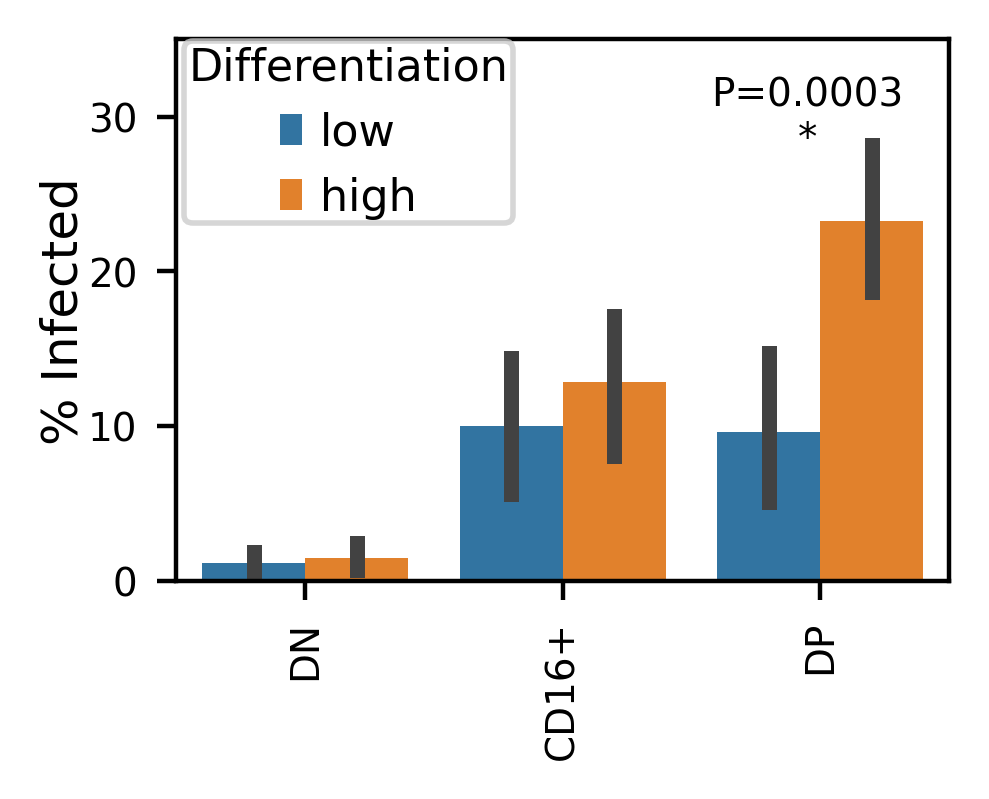

In [198]:
order = ['DN', 'CD16+', 'DP']

fig = plt.figure(figsize=(2.3, 2.15), dpi=200)
gs = gridspec.GridSpec(1, 1, fig, left=.15, bottom=.35, right=.99,top=.98,
                       hspace=0.05, wspace=0.05)
ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[])
ax.set_ylim([0,35])

ax = sns.barplot(x='Category', y='Ebola_Positive_100', data=plotdata_late, order=order,
                 hue='Category_Diff_Bin', ax=ax, hue_order=['low', 'high'])

ax.set_xticklabels(order, rotation=90)
ax.set_ylabel('% Infected', labelpad=0)
ax.set_xlabel('')

#ax.set_xlim([-.8, 4.8])

ax.legend(loc=(0.01,.66), title='Differentiation', fontsize=8, title_fontsize=8, borderpad=.1)
ax.text(1.95, 30, 'P=0.0003\n*', fontsize=7, va='center', ha='center')
ax.grid(False)

figure_file = os.path.join(results_dir, "InfectionFrac.MonoCategoryDiffBin.Invivo.Seqwell.Barplot.pdf")
fig.savefig(figure_file, dpi=200)

In [343]:
ind = (plotdata_late['Category'].isin(['DP', 'DN']))
ct = pd.crosstab(plotdata_late.loc[ind, 'Category'], plotdata_late.loc[ind, 'Category_Diff_Bin'])
print(fisher_exact(ct))
ct

(0.46400535309190016, 2.8953376025943416e-12)


Category_Diff_Bin,high,low
Category,,
DN,729,863
DP,284,156


In [344]:
for category in ['DN', 'CD16+', 'DP']:
    print(category)
    subdat = plotdata_late.loc[plotdata_late['Category']==category, :]
    ind = subdat['Ebola_Positive'] == True
    print(ranksums(subdat.loc[ind, 'diff_score'], subdat.loc[~ind, 'diff_score']))

DN
RanksumsResult(statistic=1.6573975559036407, pvalue=0.09743912523526933)
CD16+
RanksumsResult(statistic=2.460822389798765, pvalue=0.013861896954261526)
DP
RanksumsResult(statistic=6.188592535019195, pvalue=6.070376952791421e-10)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


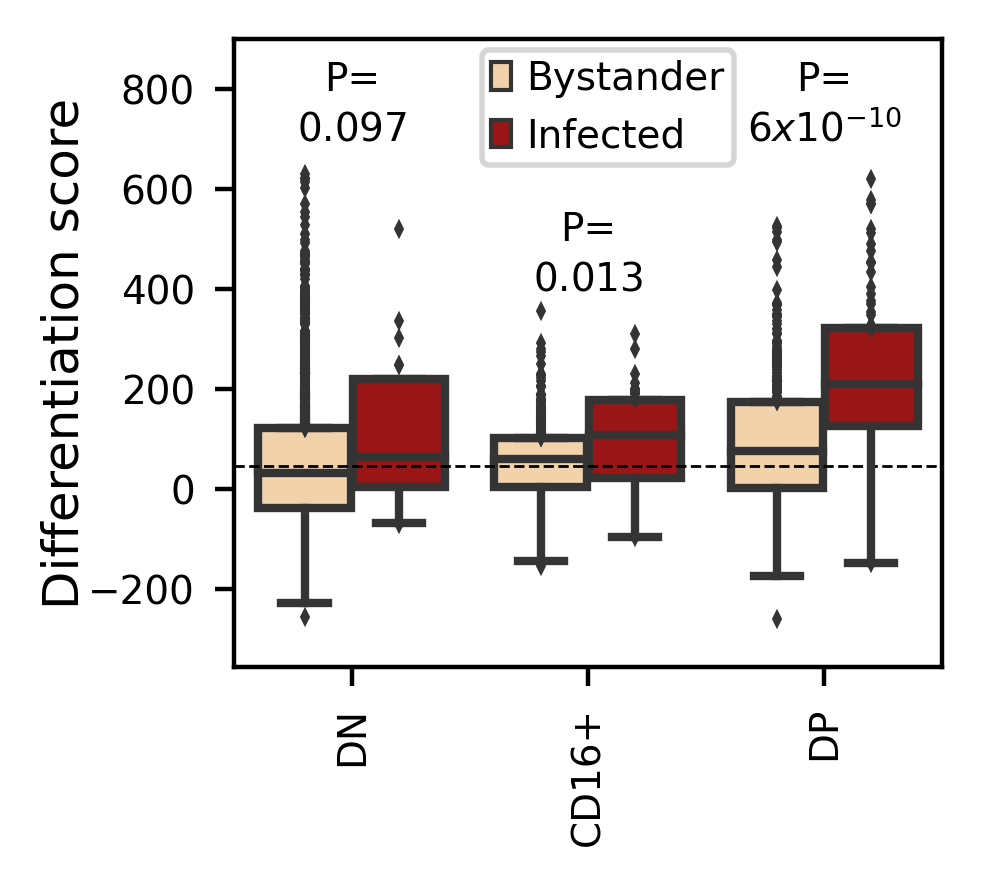

In [345]:
fig = plt.figure(figsize=(2.3, 2.15), dpi=200)
gs = gridspec.GridSpec(1, 1, fig, left=.22, bottom=.25, right=.99,top=.98,
                       hspace=0.05, wspace=0.05)
ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[])

infected_color2 = (0.680392156862745, 0.0, 0.0)

order = ['DN', 'CD16+', 'DP']

plotdata_late['Ebola_Status'] = plotdata_late['Ebola_Positive'].replace({True:'Infected', False:'Bystander'})

ax = sns.boxplot(x='Category', y='diff_score', hue='Ebola_Status', data=plotdata_late,
           order=order, palette=[uninfected_color, infected_color2], hue_order=['Bystander', 'Infected'],
           ax=ax, whis=[.025, .975], fliersize=1,)

ax.set_xticklabels(order, rotation=90)
ax.legend(title=None, fontsize=7, loc=(.35,.8),
          borderpad=.25, handletextpad=.4)


ax.text(2.0, 820, 'P=', fontsize=7, va='center', ha='center')
ax.text(2.0, 720, '$6x10^{-10}$', fontsize=7, va='center', ha='center')

ax.text(1.0, 520, 'P=', fontsize=7, va='center', ha='center')
ax.text(1.0, 420, '$0.013$', fontsize=7, va='center', ha='center')

ax.text(0, 820, 'P=', fontsize=7, va='center', ha='center')
ax.text(0, 720, '$0.097$', fontsize=7, va='center', ha='center')



'''
ax.text(3.0, 1020, 'NS', fontsize=7, va='center', ha='center')
ax.text(2.0, 1020, 'P=0.01', fontsize=7, va='center', ha='center')
ax.text(1.0, 1020, 'NS', fontsize=7, va='center', ha='center')
ax.text(0, 1020, 'NS', fontsize=7, va='center', ha='center')
'''

median = plotdata_late['diff_score'].median()
xlim = ax.get_xlim()
ax.hlines(y=median, xmin=xlim[0], xmax=xlim[1], linestyle='--', linewidth=.5)
ax.set_xlim(xlim)


ax.set_xlabel('')
ax.set_ylabel('Differentiation score', labelpad=0)
ax.grid(False)

ax.set_ylim([-357.05901984044885, 900])

figure_file = os.path.join(results_dir, "DiffScore.MonoCategoryInfectedBystander.Invivo.Seqwell.Boxplot.pdf")
fig.savefig(figure_file, dpi=200)

In [347]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [372]:
X = plotdata_late[['MAGIC_CD14', 'MAGIC_CD16']].copy()
X['CD14xCD16'] = X['MAGIC_CD14'] * X['MAGIC_CD16']
X['diff_score'] = plotdata_late['diff_score'].copy().values
Y = plotdata_late.loc[:, 'Ebola_Positive'].astype(int)

ind = ~((plotdata_late['Ebola_Positive']==False) & (plotdata_late['log10_EBOV_TPT']>0))
X = X.loc[ind,:]
Y = Y.loc[ind]


In [373]:
logit_mod = sm.Logit(Y, X)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.193765
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         Ebola_Positive   No. Observations:                 2555
Model:                          Logit   Df Residuals:                     2551
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 May 2020   Pseudo R-squ.:                  0.1109
Time:                        02:27:50   Log-Likelihood:                -495.07
converged:                       True   LL-Null:                       -556.82
Covariance Type:            nonrobust   LLR p-value:                 1.358e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MAGIC_CD14    -4.8056      0.197    -24.383      0.000      -5.192      -4.419
MAGIC_CD16    -1.0013      0.

In [73]:
ind = plotdata['DPIc'].isin(['5', '6', '7', '8']) & ~((plotdata['Ebola_Positive']==False) & (plotdata['log10_EBOV_TPT']>0))
X = plotdata[['MAGIC_CD14', 'MAGIC_CD16', 'diff_score']]
X['CD14 x CD16'] = X['MAGIC_CD14'] * X['MAGIC_CD16']

X = X.loc[ind,:]
Y = plotdata.loc[ind, 'Ebola_Positive'].astype(int)
X_scale = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)
X_scale['intercept'] = 1
X['intercept'] = 1

/opt/miniconda3/envs/py37_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
logit_mod = sm.Logit(Y, X_scale)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.202805
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         Ebola_Positive   No. Observations:                 2428
Model:                          Logit   Df Residuals:                     2423
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Mar 2020   Pseudo R-squ.:                  0.1797
Time:                        16:41:45   Log-Likelihood:                -492.41
converged:                       True   LL-Null:                       -600.31
Covariance Type:            nonrobust   LLR p-value:                 1.509e-45
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MAGIC_CD14      0.5379      0.158      3.398      0.001       0.228       0.848
MAGIC_CD16      0.7914    

In [75]:
logit_mod = sm.Logit(Y, X)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.202805
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         Ebola_Positive   No. Observations:                 2428
Model:                          Logit   Df Residuals:                     2423
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Mar 2020   Pseudo R-squ.:                  0.1797
Time:                        16:41:45   Log-Likelihood:                -492.41
converged:                       True   LL-Null:                       -600.31
Covariance Type:            nonrobust   LLR p-value:                 1.509e-45
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MAGIC_CD14      1.1318      0.333      3.398      0.001       0.479       1.785
MAGIC_CD16      0.8074    

In [76]:
X = pd.get_dummies(plotdata['Category']).drop('CD14+', axis=1)
X['diff_score'] = plotdata['diff_score'] 
X['diff_score'] = X['diff_score'] - X['diff_score'].mean()
X['diff_score'] = X['diff_score'] / X['diff_score'].std()
X['intercept'] = 1
ind = plotdata['DPIc'].isin(['5', '6', '7', '8']) & ~((plotdata['Ebola_Positive']==False) & (plotdata['log10_EBOV_TPT']>0))
X = X.loc[ind,:]
Y = plotdata.loc[ind, 'Ebola_Positive'].astype(int)

In [77]:
logit_mod = sm.Logit(Y, X)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.201135
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         Ebola_Positive   No. Observations:                 2428
Model:                          Logit   Df Residuals:                     2422
Method:                           MLE   Df Model:                            5
Date:                Mon, 09 Mar 2020   Pseudo R-squ.:                  0.1865
Time:                        16:41:46   Log-Likelihood:                -488.36
converged:                       True   LL-Null:                       -600.31
Covariance Type:            nonrobust   LLR p-value:                 2.173e-46
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
CD14+ CD16+     1.6583      0.443      3.743      0.000       0.790       2.527
CD14- CD16-    -0.8223    

In [78]:
X = pd.get_dummies(plotdata['Category'])
X['diff_score'] = plotdata['diff_score'] 
X['diff_score'] = X['diff_score'] - X['diff_score'].mean()
X['diff_score'] = X['diff_score'] / X['diff_score'].std()
#X['intercept'] = 1
ind = plotdata['DPIc'].isin(['5', '6', '7', '8']) & ~((plotdata['Ebola_Positive']==False) & (plotdata['log10_EBOV_TPT']>0))
X = X.loc[ind,:]
Y = plotdata.loc[ind, 'Ebola_Positive'].astype(int)

In [79]:
logit_mod = sm.Logit(Y, X)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.201135
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         Ebola_Positive   No. Observations:                 2428
Model:                          Logit   Df Residuals:                     2422
Method:                           MLE   Df Model:                            5
Date:                Mon, 09 Mar 2020   Pseudo R-squ.:                  0.1865
Time:                        16:41:48   Log-Likelihood:                -488.36
converged:                       True   LL-Null:                       -600.31
Covariance Type:            nonrobust   LLR p-value:                 2.173e-46
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
CD14+          -3.2429      0.417     -7.777      0.000      -4.060      -2.426
CD14+ CD16+    -1.5846    

In [346]:
plotdata_late

,batch,DPI,DPIc,Period,full_sample_id,frz_status,sample_source,sample,array_num,array_id,...,FCGR3,diff_score,MAGIC_CD14,MAGIC_CD16,MAGIC_KI67,Category,Ebola_Positive_100,Category_Diff_Quantile,Category_Diff_Bin,Ebola_Status
NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711_AAACGTCGTTTC,NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711,5,5,Mid,NHP16.D005.FRZ-MDCK.a4.std,FRZ,NHP16.D005,NHP16.D005.FRZ,a4,NHP16.D005.FRZ-MDCK.a4,...,0.091750,55.556805,1.781934,1.391876,0.872334,DP,0,"(46.285, 629.2]",high,Bystander
NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711_AAAGACCGACAC,NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711,5,5,Mid,NHP16.D005.FRZ-MDCK.a4.std,FRZ,NHP16.D005,NHP16.D005.FRZ,a4,NHP16.D005.FRZ-MDCK.a4,...,1.313080,141.385108,0.895853,1.483378,0.279268,CD16+,0,"(46.285, 629.2]",high,Bystander
NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711_AAAGTCTTTATC,NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711,5,5,Mid,NHP16.D005.FRZ-MDCK.a4.std,FRZ,NHP16.D005,NHP16.D005.FRZ,a4,NHP16.D005.FRZ-MDCK.a4,...,-0.764185,-5.497919,0.800139,0.715451,0.482763,DN,0,"(-261.44899999999996, 46.285]",low,Bystander
NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711_AACAAGGAGTGC,NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711,5,5,Mid,NHP16.D005.FRZ-MDCK.a4.std,FRZ,NHP16.D005,NHP16.D005.FRZ,a4,NHP16.D005.FRZ-MDCK.a4,...,-0.764185,274.618422,0.886846,0.338475,2.824122,DN,0,"(46.285, 629.2]",high,Bystander
NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711_AACATCCAAGAT,NHP16.D005.FRZ-MDCK.a4.std_88_Novaseq_20190711,5,5,Mid,NHP16.D005.FRZ-MDCK.a4.std,FRZ,NHP16.D005,NHP16.D005.FRZ,a4,NHP16.D005.FRZ-MDCK.a4,...,1.182293,189.977538,2.245068,2.907311,0.257858,DP,100,"(46.285, 629.2]",high,Infected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NHP08.D006.fresh.a1.DASH2x3_88_Novaseq_20190530_CCCGATGGTGCC,NHP08.D006.fresh.a1.DASH2x3_88_Novaseq_20190530,6,6,Late,NHP08.D006.fresh.a1.DASH2x3,fresh,NHP08.D006,NHP08.D006.fresh,a1,NHP08.D006.fresh.a1,...,-0.764185,105.094544,0.636858,0.668170,0.308658,DN,0,"(46.285, 629.2]",high,Bystander
NHP08.D006.fresh.a1.DASH2x3_88_Novaseq_20190530_CCCGGTGCGTCG,NHP08.D006.fresh.a1.DASH2x3_88_Novaseq_20190530,6,6,Late,NHP08.D006.fresh.a1.DASH2x3,fresh,NHP08.D006,NHP08.D006.fresh,a1,NHP08.D006.fresh.a1,...,-0.764185,2.456766,0.844663,1.017325,0.245467,DN,100,"(-261.44899999999996, 46.285]",low,Infected
NHP08.D006.fresh.a1.DASH2x3_88_Novaseq_20190530_CCTTCCACTGAA,NHP08.D006.fresh.a1.DASH2x3_88_Novaseq_20190530,6,6,Late,NHP08.D006.fresh.a1.DASH2x3,fresh,NHP08.D006,NHP08.D006.fresh,a1,NHP08.D006.fresh.a1,...,1.221155,-51.913763,1.537362,2.169258,0.198176,DP,0,"(-261.44899999999996, 46.285]",low,Bystander
NHP08.D006.fresh.a1.DASH2x3_88_Novaseq_20190530_GCGACCGTCCTC,NHP08.D006.fresh.a1.DASH2x3_88_Novaseq_20190530,6,6,Late,NHP08.D006.fresh.a1.DASH2x3,fresh,NHP08.D006,NHP08.D006.fresh,a1,NHP08.D006.fresh.a1,...,1.604647,-29.338683,0.509111,1.629463,0.154328,CD16+,0,"(-261.44899999999996, 46.285]",low,Bystander


In [202]:
outfn = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.MonocyteSubclustering.tsv'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(outfn)
plotdata.to_csv(outfn, sep='\t')

../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.MonocyteSubclustering.tsv


In [5]:
outfn = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.MonocyteSubclustering.tsv'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(outfn)
plotdata = pd.read_csv(outfn, sep='\t', index_col=0)
plotdata.head()

../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.MonocyteSubclustering.tsv


,batch,DPI,DPIc,Period,full_sample_id,frz_status,sample_source,sample,array_num,array_id,...,UMAP_2,dpi_color,CD14,FCGR3,diff_score,MAGIC_CD14,MAGIC_CD16,MAGIC_KI67,Category,Ebola_Positive_100
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,6.488738,#6DCCDA,-0.702759,1.858819,61.635471,0.014283,4.231286,0.009073,CD16+,0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AACATATCACCC,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,6.122305,#6DCCDA,-0.702759,1.452045,-53.043299,0.023510,3.898562,0.014868,CD16+,0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AACTGACCCCCT,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,7.074757,#6DCCDA,-0.702759,1.870883,32.341769,0.046305,3.967533,0.010575,CD16+,0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_ACAACCCGCCGG,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,2.648435,#6DCCDA,0.131625,-0.412211,-18.199051,2.052590,1.079986,0.021530,DP,0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AGCACTCTCGGG,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,3.058741,#6DCCDA,-0.702759,1.067722,-42.012902,0.136858,3.062542,0.012293,CD16+,0


## Differential expression between double positives and double negatives

In [203]:
adata_raw = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
sc.pp.filter_genes(adata_raw, min_cells=10)
genestokeep = ~adata_raw.var['Combined_Blacklist']
adata_raw = adata_raw[:, genestokeep]

adata_raw.obs['is_fresh'] = adata_raw.obs['frz_status'].replace({'fresh':1, 'FRZ':0})
adata_raw.obs['Monocyte_Category'] = plotdata.loc[adata_raw.obs.index, 'Category']

Trying to set attribute `.obs` of view, copying.


In [204]:
adata_raw.obs['Monocyte_Category'].unique()

array(['CD16+', 'DP', 'CD14+', 'DN'], dtype=object)

In [205]:
tokeep = (adata_raw.obs['Subclustering_reduced']=='Mono') & (adata_raw.obs['DPIc'].isin(['5','6','7','8'])) & (adata_raw.obs['Monocyte_Category'].isin(['DP','DN']))
adata_ct = adata_raw[tokeep, :]
adata_ct.obs['Category_Bin'] = adata_ct.obs['Monocyte_Category'].replace({'DN':0, 'DP':1})
sc.pp.filter_genes(adata_ct, min_cells=(.01*adata_ct.shape[0]))
sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
sc.pp.log1p(adata_ct)
adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
adata_ct.obs['cngeneson'] =  scale((adata_ct.X>0).sum(axis=1)).reshape(-1)        


Trying to set attribute `.obs` of view, copying.


filtered out 2866 genes that are detectedin less than 19.28 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [206]:
adir_local = '../../../../data/InVivo/Seqwell/'
dedir = os.path.join(adir_local, 'DE_DPvsDN')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [207]:
X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
X.to_csv(os.path.join(de_infiles, 'DPvsDN.DPI4to8.expression.csv'))
adata_ct.obs.to_csv(os.path.join(de_infiles, 'DPvsDN.DPI4to8.celldata.csv'))
adata_ct.var.to_csv(os.path.join(de_infiles, 'DPvsDN.DPI4to8.genedata.csv'))

In [208]:
ncores =4
testvar = 'Category_Bin'
covars = ['is_fresh_scale', 'cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

exprfn = os.path.join(de_infiles, 'DPvsDN.DPI4to8.expression.csv')
celldatfn = os.path.join(de_infiles, 'DPvsDN.DPI4to8.celldata.csv')
genedatfn = os.path.join(de_infiles, 'DPvsDN.DPI4to8.genedata.csv')
resultsfn = os.path.join(de_results, 'DPvsDN.DPI4to8.DE.csv')
cmd = 'Rscript ../../../Code/run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
print(cmd)
!{cmd}

Rscript ../../../Code/run_mast.R ../../../../data/InVivo/Seqwell/DE_DPvsDN/genefiles/DPvsDN.DPI4to8.expression.csv ../../../../data/InVivo/Seqwell/DE_DPvsDN/genefiles/DPvsDN.DPI4to8.celldata.csv ../../../../data/InVivo/Seqwell/DE_DPvsDN/genefiles/DPvsDN.DPI4to8.genedata.csv ../../../../data/InVivo/Seqwell/DE_DPvsDN/results/DPvsDN.DPI4to8.DE.csv 4 Category_Bin is_fresh_scale,cngeneson,percent_mito_scale
~Category_Bin + is_fresh_scale + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [==========>---------------------------------]  25% with 0 failures Completed [=>------------------------------------------]   6% 

In [209]:
import os
resultsfn = os.path.join(de_results, 'DPvsDN.DPI4to8.DE.csv')


,logFC,Q
primerid,,
FCGR3,1.685861,9.183440e-85
CD14,1.659860,6.471699e-79
FTL,0.825188,2.047364e-78
MKI67,-1.294310,5.654347e-73
ADAMDEC1,1.601107,4.408042e-72
ANP32B,-1.260163,4.671332e-69
SMC2,-0.594366,2.698265e-50
H2AFZ,-0.963934,1.474053e-49
SOD2,0.870346,2.865399e-48


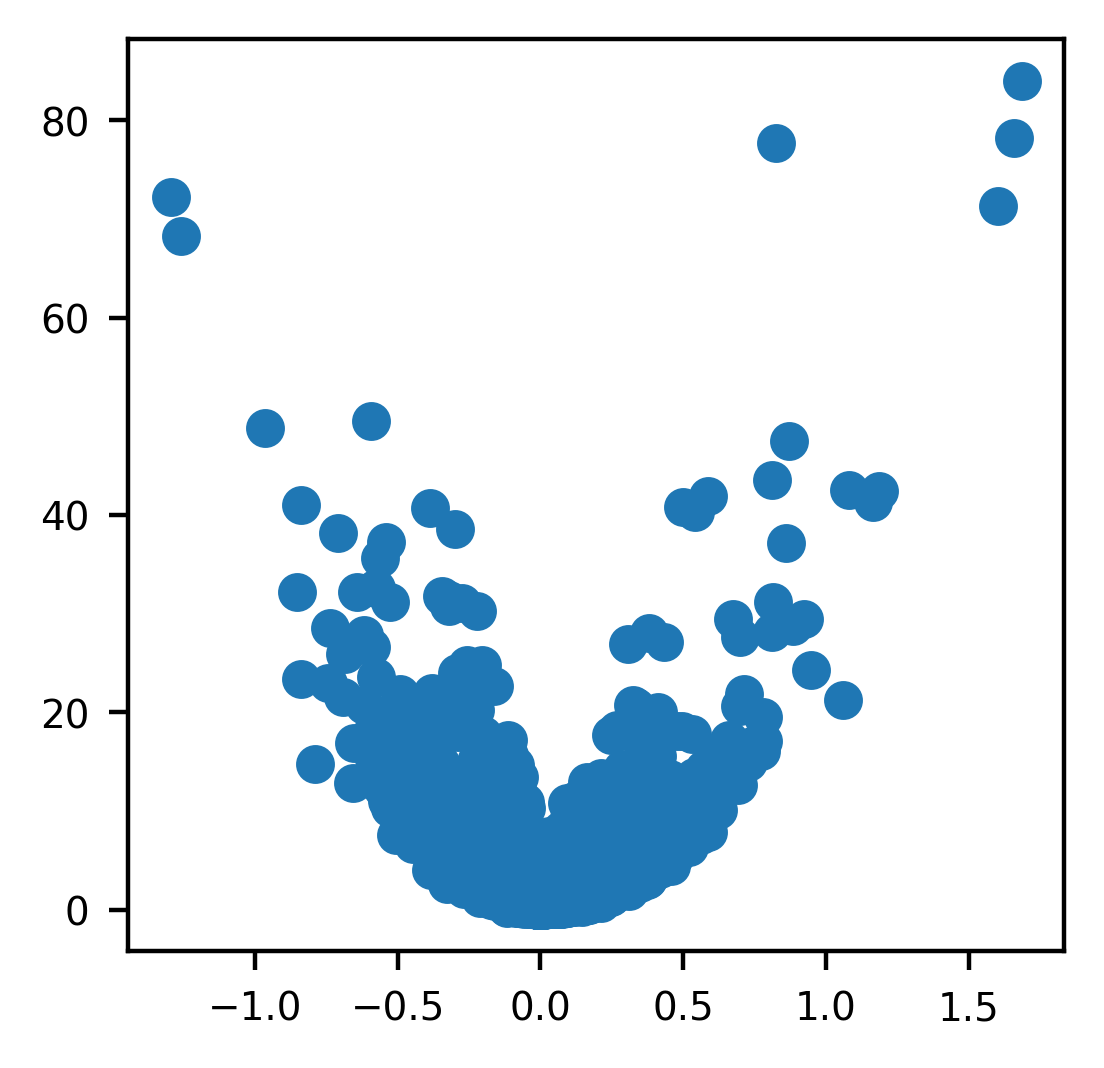

In [210]:
from statsmodels.stats.multitest import multipletests

dp_vs_dn = pd.read_csv(resultsfn).sort_values(by='P_H')
dp_vs_dn.index = dp_vs_dn['primerid']

ind = ~dp_vs_dn['P_H'].isnull()
(_, corrected, _, _) = multipletests(dp_vs_dn.loc[ind, 'P_H'], method='fdr_bh')
dp_vs_dn.loc[ind, 'Q'] = corrected
dp_vs_dn.loc[:, 'logQ'] = np.nan
dp_vs_dn.loc[ind, 'logQ'] = dp_vs_dn.loc[ind, 'Q'].apply(np.log10)*-1




(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(dp_vs_dn.loc[:,'logFC'], dp_vs_dn.loc[:,'logQ'])
ax.grid(False)

dp_vs_dn.loc[:,['logFC', 'Q']].iloc[:20,:]

In [211]:
dp_vs_dn['Label_Annot'] = 'Other'


In [212]:
bystander_deg_output = os.path.join(results_dir, 'Monocyte_Bystander_Invivo_DEG.tsv')
infVsby_m3 = pd.read_csv(bystander_deg_output, sep='\t', index_col=0)
infVsby_m3.head()

,logFC,P_H,P_C,P_D,Q,Infection_DE_Annotation,DongEtAl_Annotation,SaeedEtAl_Annotation,Italiani_M1_gene,Italiani_M2_gene,Italiani_M1orM2_gene,ISG,Annotation
gene_symbol,,,,,,,,,,,,,
S100A8,-2.031446,4.461840e-44,2.941037e-33,1.055477e-13,3.930881e-40,Significant Down,Significant Down,Significant Down,False,True,True,False,Mac. Down
S100A9,-2.016819,9.551066e-44,5.671494e-35,1.248295e-11,4.207245e-40,Significant Down,Not Significant,Significant Down,False,False,False,False,Mac. Down
ADAMDEC1,1.610543,1.583800e-33,6.526650e-17,1.999127e-19,4.533046e-30,Significant Up,Significant Up,Significant Up,False,True,True,False,Mac. Up
NR1H3,0.881882,2.058136e-33,2.460906e-03,1.343855e-32,4.533046e-30,Significant Up,Significant Up,Significant Up,False,True,True,False,Mac. Up
FTL,0.750957,2.393853e-32,1.401836e-30,2.397972e-04,4.217970e-29,Significant Up,Not Significant,Significant Up,False,False,False,False,Mac. Up


In [213]:
dp_vs_dn_merge = pd.merge(left=dp_vs_dn, right=infVsby_m3[['Annotation']], left_index=True, right_index=True, how='left')

In [214]:
dp_vs_dn_merge.loc[dp_vs_dn_merge['Annotation']=='Mac. Up','Label_Annot'] = 'Mac. Up'
dp_vs_dn_merge.loc[dp_vs_dn_merge['Annotation']=='Mac. Down','Label_Annot'] = 'Mac. Down'

In [215]:
gsetfn = '../../../../data/Genesets/msigdb/h.all.v6.2.symbols.gmt'
gset_hallmark, allgenes = load_geneset(gsetfn,  genes=list(dp_vs_dn_merge.index), minsize=10)

cell_cycle = gset_hallmark['HALLMARK_G2M_CHECKPOINT'].union(gset_hallmark['HALLMARK_E2F_TARGETS'])

In [216]:
dp_vs_dn_merge.loc[dp_vs_dn_merge['primerid'].isin(cell_cycle), 'Label_Annot'] = 'Cell Cycle'

In [223]:
dp_vs_dn_merge.loc[['CD14', 'FCGR3'], 'Label_Annot'] = 'Marker'

In [224]:
dp_vs_dn_merge.head()

,primerid,logFC,P_H,P_C,P_D,Q,logQ,Label_Annot,Annotation
primerid,,,,,,,,,
FCGR3,FCGR3,1.685861,1.039674e-88,4.322810e-12,1.143473e-79,9.183440e-85,84.036995,Marker,Marker
CD14,CD14,1.659860,1.465346e-82,3.966097e-26,1.349420e-59,6.471699e-79,78.188982,Marker,Marker
FTL,FTL,0.825188,6.953575e-82,5.562132e-81,1.186839e-03,2.047364e-78,77.688805,Mac. Up,Mac. Up
MKI67,MKI67,-1.294310,2.560556e-76,2.091748e-18,5.316332e-61,5.654347e-73,72.247618,Cell Cycle,Other
ADAMDEC1,ADAMDEC1,1.601107,2.495213e-75,2.608507e-23,3.860370e-55,4.408042e-72,71.355754,Mac. Up,Mac. Up


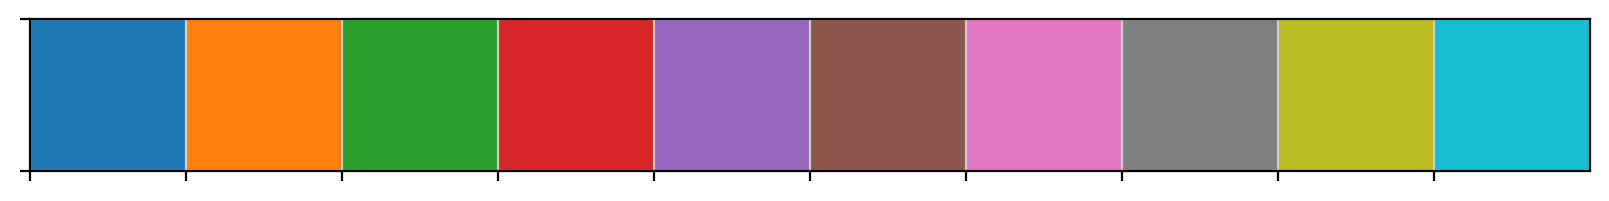

In [225]:
sns.palplot(palettable.tableau.Tableau_10.hex_colors)
colors = palettable.tableau.Tableau_10.hex_colors
cat2color = {'Mac. Up':colors[0], 'Mac. Down':colors[1], 'Other':colors[7], 'Cell Cycle':colors[2], 'EBOLA':colors[3], 'Marker':colors[6]}

In [226]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

CTSH [0.1, 0.5, 'left', 'center']
PSAP [-0.05, 3, 'right', 'bottom']
FTH1 [0.1, -2, 'left', 'center']
CX3CR1 [0, -1, 'center', 'top']
CTSD [-0.05, -2, 'center', 'top']
STMN1 [-0.05, 2, 'center', 'bottom']
S100A9 [-0.08, -1, 'right', 'top']
S100A8 [-0.1, -2, 'right', 'center']
MS4A6A [-0.04, -3, 'right', 'top']
HNRNPA2B1 [-0.07, -0.5, 'right', 'center']


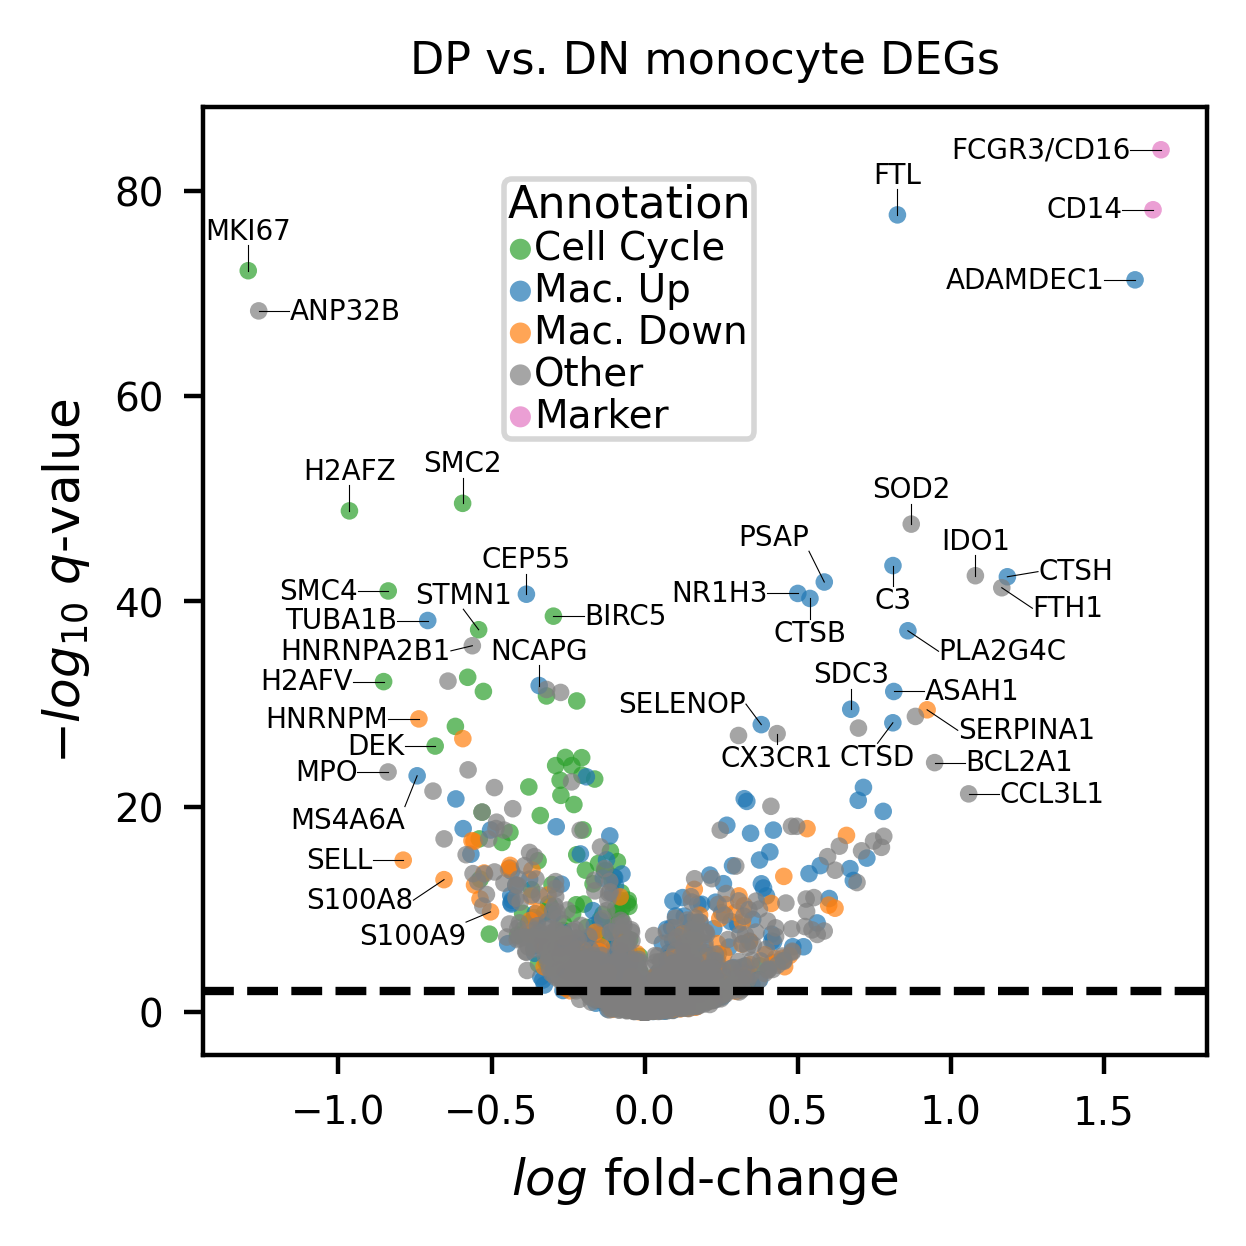

In [308]:
import matplotlib.gridspec as gridspec


fig = plt.figure(constrained_layout=True, figsize=(3.,3), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.1,
                       bottom=.1, right=.95, top=.9)
ax = fig.add_subplot(gs[0],
                     ylabel='', xlabel='',
                     title='')

order = [ 'Cell Cycle', 'Mac. Up', 'Mac. Down', 'Other', 'Marker']
xvar = 'logFC'
yvar = 'logQ'
for k in order:
    g = dp_vs_dn_merge.loc[dp_vs_dn_merge['Label_Annot']==k, :]
    #ax.scatter(g[xvar], g[yvar], label=k, s=g['size'],
    #           edgecolor='None', alpha=.7, color=cat2color[k])
    ax.scatter(g[xvar], g[yvar], label=k, s=10,
               edgecolor='None', alpha=.7, color=cat2color[k])
    
ax.grid(False)
leg = ax.legend(loc=(.3, .65), fontsize=7,
                markerscale=1.2, title='Annotation',
                title_fontsize=8,handletextpad=0.1,
                labelspacing=.1, borderpad=.09)
ax.set_xlabel('$log$ fold-change')
ax.set_ylabel('$-log_{10}$ $q$-value')
ax.set_title('DP vs. DN monocyte DEGs', fontsize=8)


default_x_shift = 0
default_y_shift = 2.5
default_ha='center'
default_va='bottom'
labfontsize=5

ordered = dp_vs_dn_merge.loc[dp_vs_dn_merge[xvar]>0,:].sort_values(by=yvar, ascending=False)
up_to_label = list(ordered.index[ordered[yvar]>35]) + ['CX3CR1', 'ASAH1', 'SERPINA1', 'SDC3', 'SELENOP', 'CTSD', 'ENSMMUG00000042343', 'BCL2A1']

ordered = dp_vs_dn_merge.loc[dp_vs_dn_merge[xvar]<0,:].sort_values(by=yvar, ascending=False)
down_to_label = list(ordered.index[ordered[yvar]>37]) + ['S100A9', 'S100A8', 'MS4A6A', 'HNRNPM', 'SELL', 'DEK', 'MPO', 'HNRNPA2B1', 'H2AFV', 'NCAPG']

rename = {'ENSMMUG00000045411':'CD300H', 'ENSMMUG00000042343':'CCL3L1', 'ENSMMUG00000012140':'PTMA', 'FCGR3':'FCGR3/CD16'}
genes_to_label = up_to_label + down_to_label

params = {
'above':{'x_shift':0, 'y_shift':2, 'ha':'center', 'va':'bottom'},
'right':{'x_shift':.1, 'y_shift':0., 'ha':'left', 'va':'center'},
'left':{'x_shift':-.1, 'y_shift':0., 'ha':'right', 'va':'center'},
'below':{'x_shift':0, 'y_shift':-2, 'ha':'center', 'va':'top'},
'upper-right':{'x_shift':.1, 'y_shift':3, 'ha':'left', 'va':'center'},
'lower-right':{'x_shift':.1, 'y_shift':-2, 'ha':'left', 'va':'center'},
'upper-left':{'x_shift':-.05, 'y_shift':2, 'ha':'right', 'va':'center'},
'lower-left':{'x_shift':-.05, 'y_shift':-2, 'ha':'right', 'va':'center'},
}

category = {
'above':['CEP55', 'IDO1', 'SOD2', 'SDC3', 'NCAPG'],
'right':['CTSH', 'ENSMMUG00000042343', 'ANP32B', 'BCL2A1', 'ASAH1', 'BIRC5'],
'left':['FCGR3', 'ADAMDEC1', 'ENSMMUG00000045411','NR1H3', 'SMC4', 'HNRNPM', 'SELL', 'DEK', 'MPO', 'H2AFV', 'TUBA1B', 'CD14'],
'below':['CTSB', 'C3'],
'upper-right':[],
'lower-right':['PLA2G4C', 'SERPINA1'],
'upper-left':['SELENOP'],
'lower-left':[],

}

other_param = {'PSAP':[-.05, 3, 'right', 'bottom'],
              'S100A9':[-.08, -1, 'right', 'top'],
               'S100A8':[-.1,-2,'right','center'],
               'MS4A6A':[-.04, -3, 'right', 'top'],
              'EBOV-GP':[.5, -2.3, 'left', 'center'],
              'EBOV-NP':[.5, -2.3, 'left', 'center'],
              'EBOV-VP40':[.6, -7.0, 'left', 'center'],
               'LTA4H':[.05,-5, 'left', 'center'],
               'FTH1':[.1, -2, 'left', 'center'],
               'CTSH':[.1, .5, 'left', 'center'],
               'LYZ':[0,3,'center','bottom'],
               'VMO1':[-.03,-4,'right','center'],
               'CTSL':[.15,-4,'left','center'],
               'ITGAL':[.2,-1,'left','center'],
               'SLC39A8':[.2,-7,'left','center'],
              'CX3CR1':[0, -1, 'center', 'top'],
              'CTSD':[-.05, -2, 'center', 'top'],
              'HNRNPA2B1':[-.07, -.5, 'right', 'center'],
               'STMN1':[-.05, 2, 'center', 'bottom']}



gene2cat = {g:c for c in category.keys() for g in category[c]}

for g in genes_to_label:

    if g in other_param:
      (x_shift,y_shift,ha,va) = other_param[g]
      print(g, other_param[g])

    elif g in gene2cat:
      x_shift = params[gene2cat[g]]['x_shift']
      y_shift = params[gene2cat[g]]['y_shift']
      ha = params[gene2cat[g]]['ha']
      va = params[gene2cat[g]]['va']
    else:
      x_shift = default_x_shift
      y_shift = default_y_shift
      ha = default_ha
      va = default_va
      #continue



    if g in rename:
      tolab = rename[g]
    else:
      tolab = g

    ax.text(dp_vs_dn_merge.loc[g, xvar]+x_shift, dp_vs_dn_merge.loc[g, yvar]+y_shift,
          tolab, fontsize=labfontsize, va=va, ha=ha)

    yline = [dp_vs_dn_merge.loc[g, yvar], dp_vs_dn_merge.loc[g, yvar]+y_shift]
    xline = [dp_vs_dn_merge.loc[g, xvar], dp_vs_dn_merge.loc[g, xvar]+x_shift]
    ax.plot(xline, yline, color='k', linewidth=.2)

    


qthresh = .01
xlim = ax.get_xlim()

ax.hlines(-1*np.log10(qthresh), xmin=xlim[0], xmax=xlim[1], linestyle='--')
ax.set_xlim(xlim)

figure_file = os.path.join(results_dir, "DifferentialExpression.Invivo.MonocyteDPvsDN.DPI5to8.Volcano.pdf")
fig.savefig(figure_file, dpi=200)

In [127]:
dp_vs_dn_merge.loc[dp_vs_dn_merge['logFC']<0, :].head(50) #head(100).tail(50)

,primerid,logFC,P_H,P_C,P_D,Q,logQ,Label_Annot,Annotation
primerid,,,,,,,,,
MKI67,MKI67,-1.305903,1.380526e-76,1.749897e-18,3.413085e-61,2.438285e-73,72.612916,Cell Cycle,Other
ANP32B,ANP32B,-1.260064,4.286428e-72,8.524457e-55,2.185178e-20,6.308907e-69,68.200046,Other,Other
SMC2,SMC2,-0.601407,1.928023e-53,5.810001e-04,3.746159e-52,2.432339e-50,49.613976,Cell Cycle,Mac. Up
H2AFZ,H2AFZ,-0.969073,1.135642e-52,7.883864e-44,9.446972e-12,1.253607e-49,48.901839,Cell Cycle,Other
SMC4,SMC4,-0.846561,1.219451e-44,4.166567e-20,1.831875e-27,6.730605e-42,41.171946,Cell Cycle,Other
CEP55,CEP55,-0.392770,3.628434e-44,1.738426e-01,5.158871e-45,1.884865e-41,40.724720,Mac. Up,Mac. Up
BIRC5,BIRC5,-0.303221,5.724237e-42,1.911121e-01,7.783205e-43,2.660565e-39,38.575026,Cell Cycle,Mac. Up
TUBA1B,TUBA1B,-0.709194,2.920816e-41,7.888199e-42,8.039041e-02,1.289686e-38,37.889516,Mac. Up,Mac. Up
STMN1,STMN1,-0.548893,1.139027e-40,3.701259e-07,2.939577e-36,4.572160e-38,37.339879,Cell Cycle,Mac. Up


In [78]:
outfn = os.path.join(results_dir, 'DPvsDN.Mono.DE.tsv')
dp_vs_dn_merge.to_csv(outfn, sep='\t')

## Marker plot

In [267]:
adata_compare_markers = adata_annot.copy()

In [268]:
adata_compare_markers.obs['Category'] = adata_compare_markers.obs['Subclustering_reduced']
adata_compare_markers.obs.loc[plotdata.index, 'Category'] = 'Mono-' + plotdata['Category']
adata_compare_markers.obs['Full_Category'] = adata_compare_markers.obs['Period'].astype(str) + '_' + adata_compare_markers.obs['Category']
adata_compare_markers.obs['Full_Category'].value_counts()

Late_Th                 7323
Late_B                  6018
Early_Th                4613
Late_Neut               3772
Late_Tc                 3691
Mid_Th                  3383
Baseline_Th             2855
Early_B                 2848
Mid_B                   2688
Mid_Tc                  2495
Early_Mono-DN           2342
Early_Tc                2163
Baseline_B              1951
Baseline_Tc             1933
Mid_Neut                1652
Late_Mono-DN            1148
Early_Mono-CD16+        1101
Baseline_NK              577
Mid_Mono-DN              444
Late_NK                  397
Baseline_Mono-CD16+      377
Early_Neut               371
Baseline_Mono-CD14+      268
Late_Mono-DP             235
Mid_Mono-DP              205
Mid_Mono-CD16+           191
Early_cDC                189
Late_pDC                 186
Late_Mono-CD16+          179
Mid_Mono-CD14+           167
Late_Plasmablast         148
Mid_NK                   147
Early_NK                 123
Early_Mono-CD14+         115
Early_pDC     

In [269]:
forplot = (adata_compare_markers.obs['Period'] == 'Late') | adata_compare_markers.obs['Full_Category'].isin(['Baseline_Mono-CD14+', 'Baseline_Mono-CD16+'])

In [271]:
#expr = pd.DataFrame(adata_compare_markers.X.todense(), index=adata_compare_markers.obs.index, columns=adata_compare_markers.var.index)
expr = pd.DataFrame(adata_compare_markers.X, index=adata_compare_markers.obs.index, columns=adata_compare_markers.var.index)
obs = adata_compare_markers.obs.copy()

In [272]:
expr = expr.loc[forplot, :]
obs = obs.loc[forplot, :]

In [273]:
average_expr = expr.groupby(obs['Full_Category']).mean()

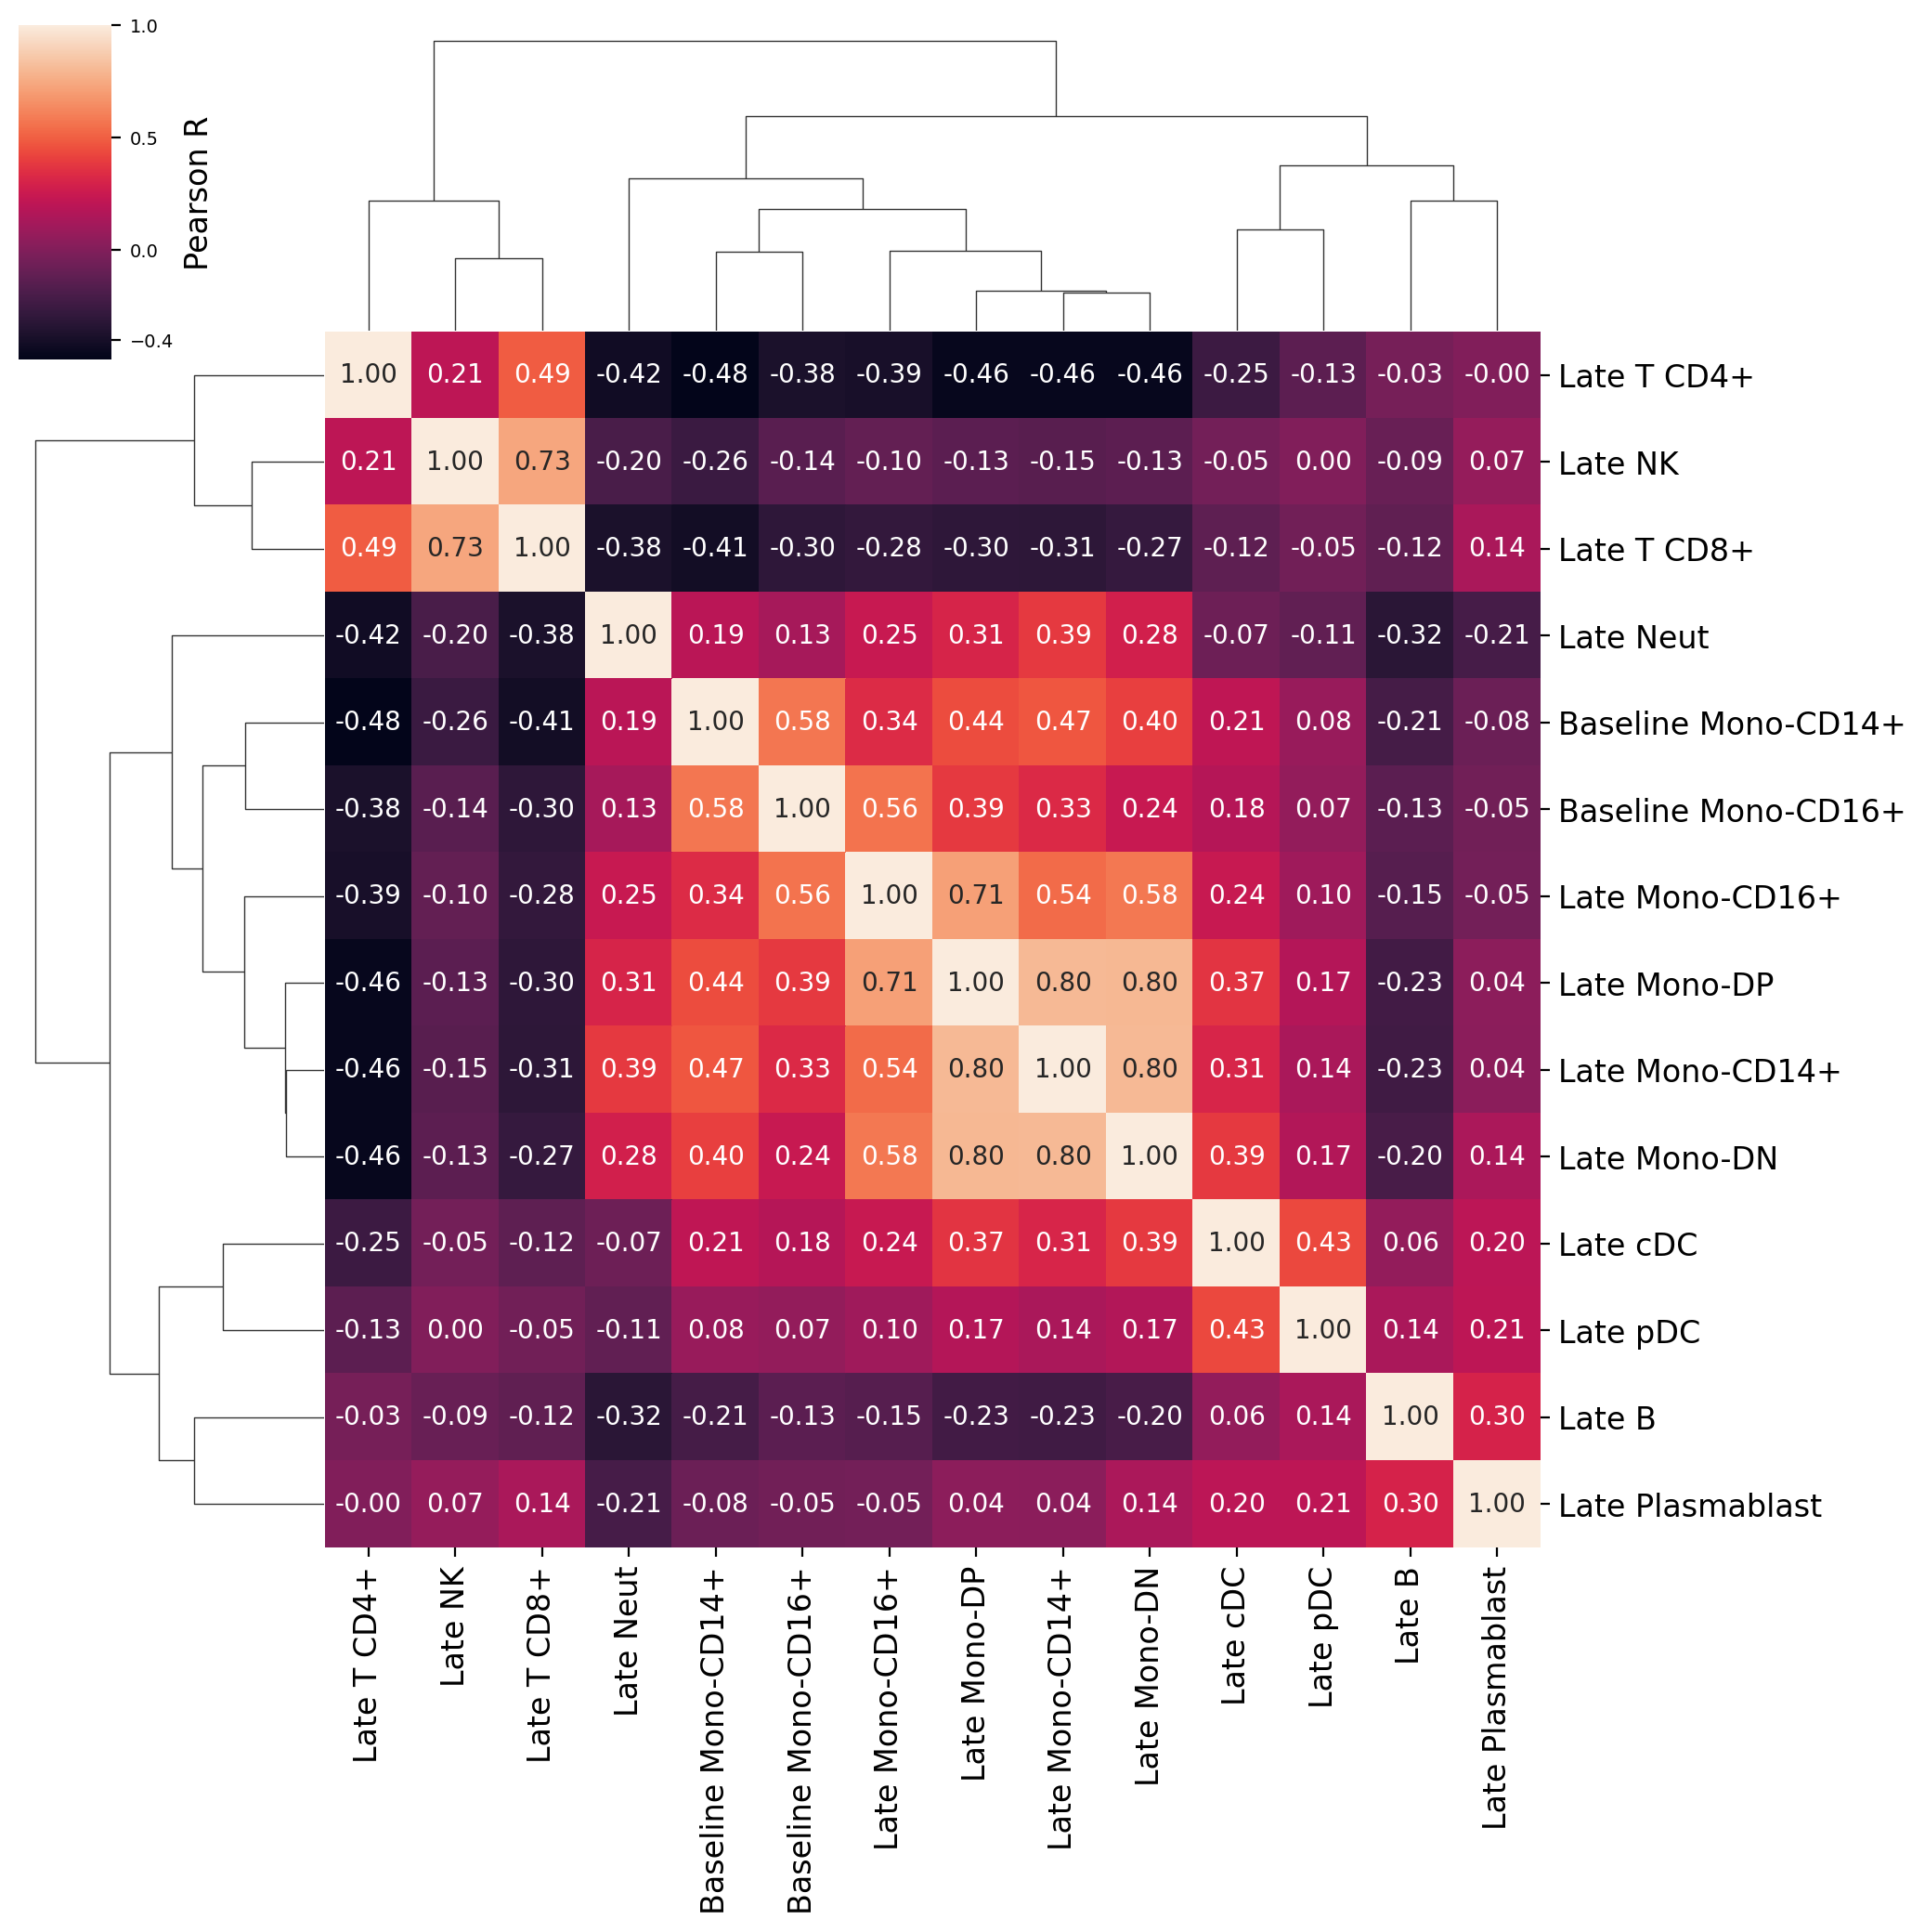

In [403]:

from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

res = sns.clustermap(average_expr.T.corr(), annot=True, annot_kws={'fontsize':10}, figsize=(10,10), fmt='.2f', cbar_kws={'ticks':[-.4, 0, .5, 1], 'label':'Pearson R'})

order = [x.get_text().replace('_', ' ').replace('Th', 'T CD4+').replace('Tc', 'T CD8+') for x in res.ax_heatmap.get_xticklabels()]
res.ax_heatmap.set_xticklabels(order, fontsize=12)
res.ax_heatmap.set_yticklabels(order, fontsize=12)
res.ax_heatmap.set_ylabel('')
res.ax_heatmap.set_xlabel('')

res.cax.yaxis.label.set_size(12)


figure_file = os.path.join(results_dir, "Clustermap.MonocyteSubtypesAndAllCells.pdf")
plt.savefig(figure_file, dpi=200, bbox_inches='tight')

## DN vs. baseline

In [98]:
tokeep_DN = (adata_raw.obs['Subclustering_reduced']=='Mono') & (adata_raw.obs['DPIc'].isin(['5','6','7','8'])) & (adata_raw.obs['Monocyte_Category'].isin(['DN']))
tokeep_CD14 = (adata_raw.obs['Subclustering_reduced']=='Mono') & (adata_raw.obs['DPIc'].isin(['0'])) & (adata_raw.obs['Monocyte_Category'].isin(['CD14+']))
tokeep = tokeep_DN | tokeep_CD14
adata_ct = adata_raw[tokeep, :]
adata_ct.obs['Category_Bin'] = adata_ct.obs['Monocyte_Category'].replace({'CD14+':0, 'DN':1}).astype(int)
sc.pp.filter_genes(adata_ct, min_cells=(.01*adata_ct.shape[0]))
sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
sc.pp.log1p(adata_ct)
adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
adata_ct.obs['cngeneson'] =  scale((adata_ct.X>0).sum(axis=1)).reshape(-1)        


Trying to set attribute `.obs` of view, copying.


filtered out 3495 genes that are detectedin less than 17.580000000000002 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [99]:
adata_ct.obs['Category_Bin'].value_counts()

1    1490
0     268
Name: Category_Bin, dtype: int64

In [100]:
pd.crosstab(adata_ct.obs['Monocyte_Category'], adata_ct.obs['DPIc'])

DPIc,0,5,6,7,8
Monocyte_Category,,,,,
CD14+,268,0,0,0,0
DN,0,354,1104,26,6


In [101]:
pd.crosstab(adata_ct.obs['Category_Bin'], adata_ct.obs['DPIc'])

DPIc,0,5,6,7,8
Category_Bin,,,,,
0,268,0,0,0,0
1,0,354,1104,26,6


In [102]:
adir_local = '../../../../data/InVivo/Seqwell/'
dedir = os.path.join(adir_local, 'DE_BaseCD14vsDN')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [103]:
X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
X.to_csv(os.path.join(de_infiles, 'BaseCD14vsDN.expression.csv'))
adata_ct.obs.to_csv(os.path.join(de_infiles, 'BaseCD14vsDN.celldata.csv'))
adata_ct.var.to_csv(os.path.join(de_infiles, 'BaseCD14vsDN.genedata.csv'))

In [104]:
ncores =4
testvar = 'Category_Bin'
covars = ['is_fresh_scale', 'cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

exprfn = os.path.join(de_infiles, 'BaseCD14vsDN.expression.csv')
celldatfn = os.path.join(de_infiles, 'BaseCD14vsDN.celldata.csv')
genedatfn = os.path.join(de_infiles, 'BaseCD14vsDN.genedata.csv')
resultsfn = os.path.join(de_results, 'BaseCD14vsDN.DE.csv')
cmd = 'Rscript ../../../Code/run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
print(cmd)
!{cmd}

Rscript ../../../Code/run_mast.R ../../../../data/InVivo/Seqwell/DE_BaseCD14vsDN/genefiles/BaseCD14vsDN.expression.csv ../../../../data/InVivo/Seqwell/DE_BaseCD14vsDN/genefiles/BaseCD14vsDN.celldata.csv ../../../../data/InVivo/Seqwell/DE_BaseCD14vsDN/genefiles/BaseCD14vsDN.genedata.csv ../../../../data/InVivo/Seqwell/DE_BaseCD14vsDN/results/BaseCD14vsDN.DE.csv 4 Category_Bin is_fresh_scale,cngeneson,percent_mito_scale
~Category_Bin + is_fresh_scale + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Warning messages:
1: In melt(coefAndCI, 

,logFC,Q
primerid,,
IFI27,3.949637,1.016636e-139
MX1,3.333463,9.727127e-115
PSAP,-1.622859,1.824029e-111
PLAC8,3.711526,5.734133e-107
ISG15,3.651933,1.397268e-88
S100A8,2.218787,1.146791e-86
CFD,-3.129624,7.767802e-84
S100A9,2.431886,8.511422e-84
VIM,-1.175182,4.328899e-78


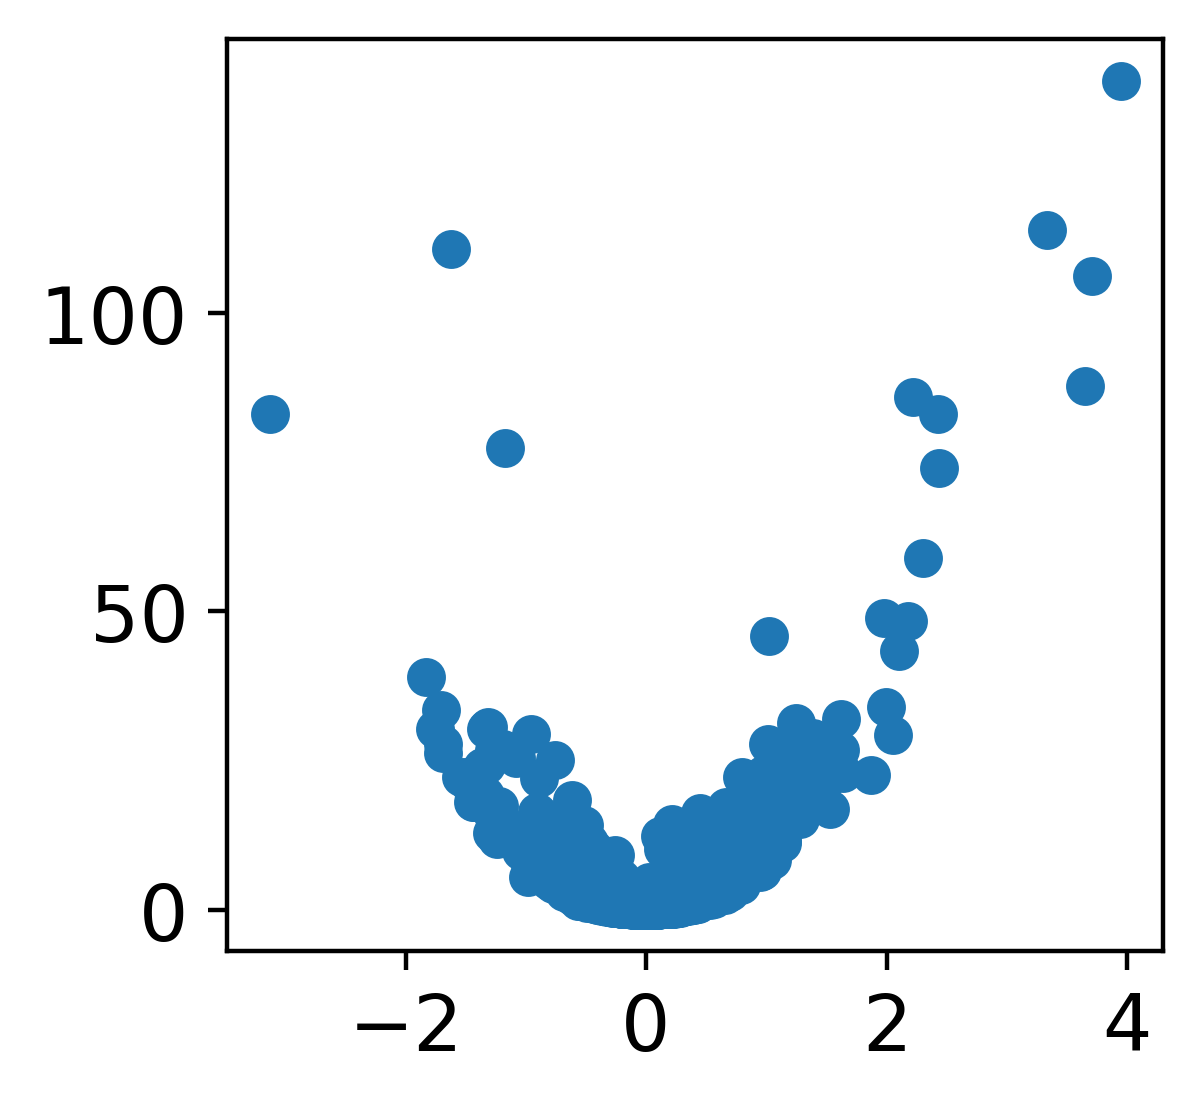

In [106]:
from statsmodels.stats.multitest import multipletests

cd14_vs_dn = pd.read_csv(resultsfn).sort_values(by='P_H')
cd14_vs_dn.index = cd14_vs_dn['primerid']

ind = ~cd14_vs_dn['P_H'].isnull()
(_, corrected, _, _) = multipletests(cd14_vs_dn.loc[ind, 'P_H'], method='fdr_bh')
cd14_vs_dn.loc[ind, 'Q'] = corrected
cd14_vs_dn.loc[:, 'logQ'] = np.nan
cd14_vs_dn.loc[ind, 'logQ'] = cd14_vs_dn.loc[ind, 'Q'].apply(np.log10)*-1




(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(cd14_vs_dn.loc[:,'logFC'], cd14_vs_dn.loc[:,'logQ'])
ax.grid(False)

cd14_vs_dn.loc[:,['logFC', 'Q']].iloc[:20,:]

In [107]:
outfn = os.path.join(results_dir, 'BaselineCD14vsDN.Mono.DE.tsv')
cd14_vs_dn.to_csv(outfn, sep='\t')

In [110]:
cd14_vs_dn.head(50)

,primerid,logFC,P_H,P_C,P_D,Q,logQ
primerid,,,,,,,
IFI27,IFI27,3.949637,1.239195e-143,1.319215e-32,2.192838e-114,1.016636e-139,138.992835
MX1,MX1,3.333463,2.371313e-118,1.539990e-53,3.620505e-68,9.727127e-115,114.012015
PSAP,PSAP,-1.622859,6.670022e-115,3.039809e-107,9.570659e-11,1.824029e-111,110.738968
PLAC8,PLAC8,3.711526,2.795774e-110,5.804023e-30,1.378032e-83,5.734133e-107,106.241532
ISG15,ISG15,3.651933,8.515773e-92,4.265020e-16,8.173935e-79,1.397268e-88,87.854720
S100A8,S100A8,2.218787,8.387066e-90,4.820236e-76,7.072369e-17,1.146791e-86,85.940516
CFD,CFD,-3.129624,6.627817e-87,2.672196e-24,8.947609e-66,7.767802e-84,83.109702
S100A9,S100A9,2.431886,8.299778e-87,5.881782e-74,5.996793e-16,8.511422e-84,83.069998
VIM,VIM,-1.175182,4.748914e-81,1.174151e-76,2.598401e-07,4.328899e-78,77.363623


In [111]:
cd14_vs_dn.head(100).tail(50)

,primerid,logFC,P_H,P_C,P_D,Q,logQ
primerid,,,,,,,
ANKRD22,ANKRD22,1.416636,1.061245e-24,3.800860e-03,5.472555e-24,1.707149e-22,21.767729
CPVL,CPVL,-1.434648,1.347394e-24,7.417562e-02,5.076731e-25,2.125773e-22,21.672483
B2M,B2M,1.310399,1.470951e-24,6.914609e-11,2.441610e-16,2.276921e-22,21.642652
IFI16,IFI16,1.477507,2.317293e-24,3.208151e-07,9.439095e-20,3.520568e-22,21.453387
PRCP,PRCP,-1.485252,2.555132e-24,1.495329e-02,3.848769e-24,3.811327e-22,21.418924
CLU,CLU,1.404950,1.673677e-23,8.825426e-03,4.118733e-23,2.451937e-21,20.610491
CD14,CD14,-1.408080,2.899894e-22,2.539752e-03,2.295718e-21,4.173812e-20,19.379467
ZFP36,ZFP36,-1.336235,3.652585e-22,2.089432e-08,2.316189e-16,5.166519e-20,19.286802
ENSMMUG00000013257,ENSMMUG00000013257,1.081691,4.960932e-22,2.402198e-03,4.159292e-21,6.898217e-20,19.161263
